# ShopTalk – RAG Prototype (Hybrid Search)

**Project:** ShopTalk – AI-Powered Shopping Assistant  
**Dataset:** [Amazon Berkeley Objects (ABO)](https://amazon-berkeley-objects.s3.amazonaws.com/index.html)  
**Author:** Balaji Gurusala  
**Notebook Scope:** T000d from `.spec/tasks.md` – RAG Prototyping  
**Prerequisite:** `02-image-captioning.ipynb` must have been run (produces enriched metadata + embedding artifacts in `/kaggle/working/`)  
**Environment:** Local MacBook (Apple Silicon / MPS) recommended; also works on Kaggle (CUDA) or CPU (slower)

---

### Purpose

Build and evaluate a **Hybrid Search** prototype that combines:

| Signal | Model | Dimension | Source |
|--------|-------|-----------|--------|
| **Text similarity** | `all-MiniLM-L6-v2` (SentenceTransformer) | 384 | Enriched text (title + bullets + caption + keywords) |
| **Image similarity** | `openai/clip-vit-base-patch32` (CLIP) | 512 | Pre-computed CLIP image embeddings from NB02 |

**Hybrid score** = `α · text_sim + (1 − α) · image_sim`  (default α = 0.6 per architecture.md)

### Inputs (from NB02)

| Artifact | Description |
|----------|-------------|
| `enriched_products_full.pkl` / `enriched_products.pkl` / `enriched_products.csv` | Enriched metadata export |
| `embedding_index.csv` | Row-aligned index mapping `item_id` → embedding row |
| `image_embeddings.npy` | Pre-computed CLIP image embeddings (primary image index) |
| `text_embeddings.npy` *(optional)* | Reused only when compatible with current text encoder dimension |
| `hybrid_embeddings.npy` *(optional)* | Loaded for diagnostics/experiments |

### Notebook Outline

1. **Step 0** – Environment Setup & Hardware Detection  
2. **Step 1** – Load Enriched Data & Pre-computed Artifacts  
3. **Step 2** – Load Models (SentenceTransformer + CLIP) — *loaded once per constitution.md*  
4. **Step 3** – Build Retrieval Indexes (In-Memory + Persistent ChromaDB)  
5. **Step 4** – Hybrid Search Function (Chroma default, In-Memory fallback)  
6. **Step 5** – Evaluation Benchmark (Precision@5, Alpha Sweep)  
7. **Step 6** – Interactive Demo with Image Visualization  
8. **Summary & Next Steps**

---

## Step 0 – Environment Setup & Hardware Detection

In [10]:
# ============================================================
# Step 0: Environment Setup & Hardware Detection
# ============================================================
# Per constitution.md: Code must detect mps (Mac) vs cuda (Kaggle/AWS) dynamically.
# Per constitution.md: Use pathlib for all paths, tqdm for loops.

import os
import sys
import time
import warnings
from pathlib import Path
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from PIL import Image

import torch
from IPython.display import display, HTML

# Settings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120
pd.set_option("display.max_colwidth", 120)

# --- Hardware Detection (constitution.md: dynamic mps/cuda/cpu) ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    GPU_NAME = torch.cuda.get_device_name(0)
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    GPU_NAME = "Apple Silicon (MPS)"
else:
    DEVICE = torch.device("cpu")
    GPU_NAME = "CPU"

print(f"Python {sys.version}")
print(f"PyTorch {torch.__version__}")
print(f"Device: {DEVICE} ({GPU_NAME})")
print(f"\nEnvironment ready.")

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch 2.8.0+cu126
Device: cuda (Tesla T4)

Environment ready.


---

## Step 1 – Load Enriched Data & Pre-computed Artifacts

Load the outputs produced by `02-image-captioning.ipynb`:

- `enriched_products.pkl` / `enriched_products_full.pkl` / `enriched_products.csv` — product metadata  
- `embedding_index.csv` — maps embedding rows to `item_id` and `product_type_flat`  
- `image_embeddings.npy` — pre-computed CLIP image embeddings (primary image index)  
- `text_embeddings.npy` *(optional)* — loaded when present, used only if shape is compatible with current text model  
- `hybrid_embeddings.npy` *(optional)* — loaded for diagnostics/experiments

The notebook auto-detects data paths for both **local** and **Kaggle** environments and reports which artifacts are used vs skipped.

We load the cleaned DataFrame produced by `02-image-captioning.ipynb`.  

In [6]:
# 1. Unzip the artifacts from the previous notebook (02-image-captioning)
# Note: Ensure the path matches the '02_image_captioning' folder in your sidebar
!unzip -o -q ../input/notebooks/balajigurusala/02-image-captioning/_output_.zip -d /kaggle/working/

In [11]:
# ============================================================
# Step 1: Load Enriched Data & Pre-computed Artifacts
# ============================================================

# --- Flexible path detection (local vs Kaggle) ---
ENRICHED_CANDIDATES = [
    Path("/kaggle/working/enriched_products_full.pkl"),
    Path("/kaggle/working/enriched_products.pkl"),
    Path("/kaggle/working/enriched_products.csv"),
    Path("./enriched_products_full.pkl"),
    Path("./enriched_products.pkl"),
    Path("./enriched_products.csv"),
    Path("./data/enriched_products_full.pkl"),
    Path("./data/enriched_products.pkl"),
    Path("./data/enriched_products.csv"),
    Path("../data/enriched_products_full.pkl"),
    Path("../data/enriched_products.pkl"),
    Path("../data/enriched_products.csv"),
]

# Locate enriched metadata artifact
DATA_DIR: Optional[Path] = None
df_raw: Optional[pd.DataFrame] = None
loaded_enriched_path: Optional[Path] = None

for candidate in ENRICHED_CANDIDATES:
    if candidate.exists():
        if candidate.suffix.lower() == ".csv":
            df_raw = pd.read_csv(candidate)
        else:
            df_raw = pd.read_pickle(candidate)
        DATA_DIR = candidate.parent
        loaded_enriched_path = candidate
        print(f"\u2713 Loaded enriched data from: {candidate}")
        break

if df_raw is None:
    raise FileNotFoundError(
        "Could not find enriched metadata artifact in any known path.\n"
        f"Checked: {[str(p) for p in ENRICHED_CANDIDATES]}\n"
        "Please download NB02 exports and place them in /kaggle/working, ./data, or ./"
    )

# --- Load embedding artifacts ---
EMBED_INDEX_PATH = DATA_DIR / "embedding_index.csv"
IMAGE_EMB_PATH = DATA_DIR / "image_embeddings.npy"
TEXT_EMB_PATH = DATA_DIR / "text_embeddings.npy"
HYBRID_EMB_PATH = DATA_DIR / "hybrid_embeddings.npy"

assert EMBED_INDEX_PATH.exists(), f"Missing: {EMBED_INDEX_PATH}"
assert IMAGE_EMB_PATH.exists(), f"Missing: {IMAGE_EMB_PATH}"

embedding_index = pd.read_csv(EMBED_INDEX_PATH)
image_embeddings_raw = np.load(IMAGE_EMB_PATH)
text_embeddings_raw = np.load(TEXT_EMB_PATH) if TEXT_EMB_PATH.exists() else None
hybrid_embeddings_raw = np.load(HYBRID_EMB_PATH) if HYBRID_EMB_PATH.exists() else None

print(f"\u2713 Loaded embedding_index.csv: {embedding_index.shape}")
print(f"\u2713 Loaded image_embeddings.npy: {image_embeddings_raw.shape}")
print(
    f"\u2713 Loaded text_embeddings.npy:  {text_embeddings_raw.shape}"
    if text_embeddings_raw is not None
    else "- text_embeddings.npy not found (optional)"
)
print(
    f"\u2713 Loaded hybrid_embeddings.npy: {hybrid_embeddings_raw.shape}"
    if hybrid_embeddings_raw is not None
    else "- hybrid_embeddings.npy not found (optional)"
)

# --- Detect image base path ---
IMAGE_CANDIDATES = [
    DATA_DIR / "images" / "small",
    Path("./data/images/small"),
    Path("../data/images/small"),
    Path("/kaggle/working/data/images/small"),
    Path("data/images/small"),
]
IMAGE_BASE: Optional[Path] = None
for candidate in IMAGE_CANDIDATES:
    if candidate.exists():
        IMAGE_BASE = candidate
        print(f"\u2713 Image base path: {IMAGE_BASE}")
        break
if IMAGE_BASE is None:
    print("\u26a0\ufe0f Image base path not found \u2014 image display will be disabled.")

# --- Align products with embeddings ---
# Only keep products that have pre-computed CLIP image embeddings
embedded_ids = set(embedding_index["item_id"].tolist())
df = df_raw[df_raw["item_id"].isin(embedded_ids)].copy().reset_index(drop=True)

# Build item_id -> embedding row mapping
id_to_emb_row = dict(zip(embedding_index["item_id"], embedding_index["row_id"]))
emb_row_order = [id_to_emb_row[iid] for iid in df["item_id"]]

# Align all available embedding artifacts to the filtered dataframe order
image_embeddings_aligned = image_embeddings_raw[emb_row_order]
text_embeddings_aligned = (
    text_embeddings_raw[emb_row_order] if text_embeddings_raw is not None else None
)
hybrid_embeddings_aligned = (
    hybrid_embeddings_raw[emb_row_order] if hybrid_embeddings_raw is not None else None
)

print(f"\nAligned dataset: {len(df):,} products with metadata + image embeddings")
print(f"Image embedding shape:   {image_embeddings_aligned.shape}")
if text_embeddings_aligned is not None:
    print(f"Text embedding shape:    {text_embeddings_aligned.shape}")
if hybrid_embeddings_aligned is not None:
    print(f"Hybrid embedding shape:  {hybrid_embeddings_aligned.shape}")
print(f"Product types: {df['product_type_flat'].nunique()} unique categories")

✓ Loaded enriched data from: /kaggle/working/enriched_products_full.pkl
✓ Loaded embedding_index.csv: (9190, 4)
✓ Loaded image_embeddings.npy: (9190, 512)
✓ Loaded text_embeddings.npy:  (9190, 512)
✓ Loaded hybrid_embeddings.npy: (9190, 512)
✓ Image base path: data/images/small

Aligned dataset: 9,190 products with metadata + image embeddings
Image embedding shape:   (9190, 512)
Text embedding shape:    (9190, 512)
Hybrid embedding shape:  (9190, 512)
Product types: 334 unique categories


In [12]:
# --- Quick data preview ---
print("Columns:", list(df.columns))
print(f"\nField coverage:")
for col in ["enriched_text", "item_name_flat", "bullet_point_flat",
            "image_caption", "product_type_flat"]:
    if col in df.columns:
        n = df[col].notna().sum()
        print(f"  {col:30s} {n:,} / {len(df):,} ({n / len(df):.1%})")

print(f"\nTop 10 product types:")
display(df["product_type_flat"].value_counts().head(10).to_frame("count"))
df.head(3)

Columns: ['brand', 'bullet_point', 'color', 'item_id', 'item_name', 'model_name', 'model_number', 'model_year', 'product_type', 'style', 'main_image_id', 'other_image_id', 'item_keywords', 'country', 'marketplace', 'domain_name', 'node', 'item_dimensions', 'item_weight', 'material', 'fabric_type', 'color_code', 'product_description', 'spin_id', '3dmodel_id', 'pattern', 'finish_type', 'item_shape', 'item_name_flat', 'brand_flat', 'color_flat', 'fabric_type_flat', 'finish_type_flat', 'material_flat', 'pattern_flat', 'style_flat', 'bullet_point_flat', 'item_keywords_flat', 'product_description_flat', 'product_type_flat', 'item_weight_flat', 'item_length_flat', 'title_length', 'desc_word_count', 'keyword_count', 'image_id', 'path', 'image_caption', 'detection_confidence', 'detection_hit', 'enriched_text']

Field coverage:
  enriched_text                  9,190 / 9,190 (100.0%)
  item_name_flat                 9,190 / 9,190 (100.0%)
  bullet_point_flat              8,178 / 9,190 (89.0%)
  i

count
product_type_flat              
CELLULAR_PHONE_CASE        4099
SHOES                       758
GROCERY                     409
HOME                        342
HOME_BED_AND_BATH           202
HOME_FURNITURE_AND_DECOR    154
CHAIR                       125
FINERING                    118
BOOT                        115
SANDAL                      107

brand  \
0         [{'language_tag': 'nl_NL', 'value': 'find.'}]   
1  [{'language_tag': 'es_MX', 'value': 'AmazonBasics'}]   
2  [{'language_tag': 'en_AE', 'value': 'AmazonBasics'}]   

                                                                                                              bullet_point  \
0  [{'language_tag': 'nl_NL', 'value': 'Schoen in Loafer-stijl'}, {'language_tag': 'nl_NL', 'value': 'Platform hak'}, {...   
1  [{'language_tag': 'es_MX', 'value': 'White Powder Coat Finish'}, {'language_tag': 'es_MX', 'value': '55-Lbs max weig...   
2  [{'language_tag': 'en_AE', 'value': '3D printer filament with 1.75mm diameter + / - .05mm; designed to fit most comm...   

                                                             color  \
0  [{'language_tag': 'nl_NL', 'value': 'Veelkleurig Vrouw Blauw'}]   
1        [{'language_tag': 'es_MX', 'value': 'White Powder Coat'}]   
2       [{'language_tag': 'en_AE', 'value': 'Translucent Yellow'}]   

      item_id  \
0  B06X9STHNG   
1  B07P8ML82R   
2  B07H9GMYXS   

                                                                                                                 item_name  \
0  [{'language_tag': 'nl_NL', 'value': 'Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,...   
1                      [{'language_tag': 'es_MX', 'value': '22" Bottom Mount Drawer Slides, White Powder Coat, 10 Pairs'}]   
2  [{'language_tag': 'en_AE', 'value': 'AmazonBasics PETG 3D Printer Filament, 1.75mm, 1 kg Spool 1.75mm AMG10528516-10'}]   

                                      model_name  \
0  [{'language_tag': 'nl_NL', 'value': '37753'}]   
1                                            NaN   
2                                            NaN   

                    model_number         model_year  \
0        [{'value': '12-05-04'}]  [{'value': 2017}]   
1   [{'value': 'AB5013-R22-10'}]                NaN   
2  [{'value': 'AMG10528516-10'}]                NaN   

                           product_type  \
0                  [{'value': 'SHOES'}]   
1               [{'value': 'HARDWARE'}]   
2  [{'value': 'MECHANICAL_COMPONENTS'}]   

                                                          style  ...  \
0  [{'language_tag': 'nl_NL', 'value': 'Gesloten-teen pompen'}]  ...   
1              [{'language_tag': 'es_MX', 'value': '10 pares'}]  ...   
2                [{'language_tag': 'en_AE', 'value': '1-Pack'}]  ...   

  item_length_flat title_length desc_word_count keyword_count     image_id  \
0              NaN           83               0            10  81iZlv3bjpL   
1            22.00           59               0            43  619y9YG9cnL   
2             9.21           79               0            10  81NP7qh2L6L   

              path  \
0  8c/8ccb5859.jpg   
1  9f/9f76d27b.jpg   
2  66/665cc994.jpg   

                                                                                    image_caption  \
0                                                          a product photo of women leather shoes   
1                                               a product photo of bottom mount kit for a product   
2  a product photo of petg printer fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi fi   

  detection_confidence detection_hit  \
0                  NaN         False   
1                  NaN         False   
2             0.131067          True   

                                                                                                             enriched_text  
0  Amazon-merk - vinden. Dames Leder Gesloten Teen Hakken,Veelkleurig Vrouw Blauw,5 UK . Schoen in Loafer-stijl | Platf...  
1  22" Bottom Mount Drawer Slides, White Powder Coat, 10 Pairs . White Powder Coat Finish | 55-Lbs max weight capacity ...  
2  AmazonBasics PETG 3D Printer Filament, 1.75mm, 1 kg Spool 1.75mm AMG10528516-10 . 3D printer filament with 1.75mm di...  

[3 rows x 51 columns]

In [13]:
# ============================================================
# Step 1b: NB02 -> NB03 Artifact Contract Checks
# ============================================================
# Run this right after Step 1 to validate producer-consumer continuity.

print("Running NB02 -> NB03 artifact checks...")

# 1) Required artifacts exist
required_paths = {
    "embedding_index.csv": EMBED_INDEX_PATH,
    "image_embeddings.npy": IMAGE_EMB_PATH,
}
for name, p in required_paths.items():
    assert p.exists(), f"Missing required artifact: {name} at {p}"

# 2) Optional artifacts (informational)
optional_status = {
    "text_embeddings.npy": TEXT_EMB_PATH.exists(),
    "hybrid_embeddings.npy": HYBRID_EMB_PATH.exists(),
}

# 3) Row-count consistency across required files
n_index = len(embedding_index)
n_img = int(image_embeddings_raw.shape[0])
assert n_index == n_img, (
    "Row mismatch: embedding_index.csv vs image_embeddings.npy "
    f"({n_index} vs {n_img})"
)

# 4) Basic schema checks
required_cols = {"item_id", "row_id"}
missing_cols = required_cols.difference(set(embedding_index.columns))
assert not missing_cols, f"embedding_index.csv missing columns: {missing_cols}"
assert embedding_index["item_id"].isna().sum() == 0, "Null item_id found in embedding_index.csv"
assert embedding_index["row_id"].isna().sum() == 0, "Null row_id found in embedding_index.csv"

# 5) item_id uniqueness and coverage
assert embedding_index["item_id"].astype(str).nunique() == n_index, (
    "item_id in embedding_index.csv must be unique"
)

meta_ids = set(df_raw["item_id"].astype(str).tolist())
index_ids = set(embedding_index["item_id"].astype(str).tolist())
missing_in_meta = index_ids - meta_ids
assert len(missing_in_meta) == 0, (
    f"{len(missing_in_meta)} embedding item_ids not found in enriched metadata"
)

# 6) Optional artifact shape checks when present
if text_embeddings_raw is not None:
    assert text_embeddings_raw.shape[0] == n_index, (
        "Row mismatch: text_embeddings.npy vs embedding_index.csv "
        f"({text_embeddings_raw.shape[0]} vs {n_index})"
    )
if hybrid_embeddings_raw is not None:
    assert hybrid_embeddings_raw.shape[0] == n_index, (
        "Row mismatch: hybrid_embeddings.npy vs embedding_index.csv "
        f"({hybrid_embeddings_raw.shape[0]} vs {n_index})"
    )

print("✓ Required artifacts present and row-aligned")
print(f"  embedding_index rows: {n_index:,}")
print(f"  image_embeddings rows: {n_img:,}")
print(f"  text_embeddings present:  {optional_status['text_embeddings.npy']}")
print(f"  hybrid_embeddings present: {optional_status['hybrid_embeddings.npy']}")
print(f"  metadata source: {loaded_enriched_path}")

Running NB02 -> NB03 artifact checks...
✓ Required artifacts present and row-aligned
  embedding_index rows: 9,190
  image_embeddings rows: 9,190
  text_embeddings present:  True
  hybrid_embeddings present: True
  metadata source: /kaggle/working/enriched_products_full.pkl


---

## Step 2 – Load Models (Once)

Per `constitution.md` — **“Load Models Once”**: models are initialized a single time and reused.

| Model | Purpose | Dimension |
|-------|---------|-----------|
| `all-MiniLM-L6-v2` (SentenceTransformer) | Encode enriched text **and** user queries | 384 |
| `openai/clip-vit-base-patch32` (CLIP) | Encode user queries for image similarity | 512 |

> **Note:** CLIP is used **only for query encoding** here. The product image embeddings were pre-computed in NB02.

In [14]:
# ============================================================
# Step 2: Load Models (SentenceTransformer + CLIP)
# ============================================================
# Per constitution.md: Load models once; dynamic device detection.

from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel

# --- Config ---
ST_MODEL_ID = "all-MiniLM-L6-v2"
CLIP_MODEL_ID = "openai/clip-vit-base-patch32"

# --- SentenceTransformer (text encoder) ---
print(f"Loading SentenceTransformer: {ST_MODEL_ID} ...")
t0 = time.time()
st_model = SentenceTransformer(ST_MODEL_ID, device=str(DEVICE))
print(f"\u2713 SentenceTransformer loaded in {time.time() - t0:.1f}s")

# --- CLIP (query-to-image encoder) ---
print(f"\nLoading CLIP: {CLIP_MODEL_ID} ...")
t0 = time.time()
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_ID)
clip_model = CLIPModel.from_pretrained(CLIP_MODEL_ID).to(DEVICE).eval()
print(f"\u2713 CLIP loaded in {time.time() - t0:.1f}s")

print(f"\nModels loaded on: {DEVICE} ({GPU_NAME})")
print(f"  SentenceTransformer dim: {st_model.get_sentence_embedding_dimension()}")
print(f"  CLIP dim: {clip_model.config.projection_dim}")

2026-02-13 21:45:56.866163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771019157.272663      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771019157.392798      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771019158.322468      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771019158.322510      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771019158.322513      55 computation_placer.cc:177] computation placer alr

Loading SentenceTransformer: all-MiniLM-L6-v2 ...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ SentenceTransformer loaded in 3.4s

Loading CLIP: openai/clip-vit-base-patch32 ...


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

✓ CLIP loaded in 4.7s

Models loaded on: cuda (Tesla T4)
  SentenceTransformer dim: 384
  CLIP dim: 512


---

## Step 3 – Build Retrieval Indexes (In-Memory + Persistent ChromaDB)

This notebook now supports two retrieval backends:

1. **In-Memory (NumPy)**: Fast local prototyping and metric sweeps  
2. **Persistent ChromaDB**: Production-shaped retrieval with on-disk persistence

Implementation steps:

1. **Text embeddings**: Encode all `enriched_text` with SentenceTransformer → (N, 384)  
2. **Image embeddings**: Use pre-computed CLIP image embeddings from NB02 → (N, 512)  
3. **L2-normalize** both indexes for cosine similarity  
4. **Optional Chroma upsert** into two collections (`products_text`, `products_image`)

In [15]:
# Install ChromaDB for vector storage
!pip install -q chromadb

In [16]:
import chromadb
print(f"ChromaDB version: {chromadb.__version__}")

ChromaDB version: 1.5.0


In [17]:
# ============================================================
# Step 3: Build Retrieval Indexes
# ============================================================


def l2_normalize(x: np.ndarray) -> np.ndarray:
    """L2-normalize vectors row-wise for cosine similarity via dot product.

    Args:
        x: Array of shape (N, D).

    Returns:
        L2-normalized array of same shape.
    """
    norms = np.linalg.norm(x, axis=1, keepdims=True)
    return x / np.maximum(norms, 1e-12)


# --- 3a: Prepare text embeddings (reuse NB02 artifact when compatible) ---
texts = df["enriched_text"].fillna("").tolist()
expected_text_dim = st_model.get_sentence_embedding_dimension()

use_precomputed_text = (
    text_embeddings_aligned is not None
    and text_embeddings_aligned.ndim == 2
    and text_embeddings_aligned.shape[0] == len(df)
    and text_embeddings_aligned.shape[1] == expected_text_dim
)

if use_precomputed_text:
    text_embeddings = text_embeddings_aligned.astype(np.float32)
    print(
        "Using precomputed text_embeddings.npy from NB02 "
        f"(shape={text_embeddings.shape})"
    )
else:
    if text_embeddings_aligned is not None:
        print(
            "text_embeddings.npy found but incompatible with current text encoder; "
            f"expected dim={expected_text_dim}, got dim={text_embeddings_aligned.shape[1]}."
        )
        print("Falling back to fresh SentenceTransformer encoding...")
    else:
        print("Generating text embeddings with SentenceTransformer ...")

    BATCH_SIZE = 128 if DEVICE.type == "cuda" else 64
    t0 = time.time()
    text_embeddings = st_model.encode(
        texts,
        batch_size=BATCH_SIZE,
        show_progress_bar=True,
        normalize_embeddings=True,
        convert_to_numpy=True,
    )
    elapsed = time.time() - t0
    print(f"\u2713 Text embeddings generated in {elapsed:.1f}s "
          f"({len(texts) / elapsed:.0f} items/s)")
    print(f"  Shape: {text_embeddings.shape}")

# --- 3b: Prepare normalized indexes ---
image_embeddings_norm = l2_normalize(image_embeddings_aligned.astype(np.float32))
text_embeddings_norm = l2_normalize(text_embeddings.astype(np.float32))

TEXT_INDEX = text_embeddings_norm    # (N, 384)
IMAGE_INDEX = image_embeddings_norm  # (N, 512)

ITEM_IDS = df["item_id"].astype(str).tolist()
ITEM_ID_TO_DF_INDEX = {iid: i for i, iid in enumerate(ITEM_IDS)}

print(f"\n\u2713 In-memory indexes built:")
print(f"  TEXT_INDEX:  {TEXT_INDEX.shape}  (SentenceTransformer, L2-normed)")
print(f"  IMAGE_INDEX: {IMAGE_INDEX.shape} (CLIP, L2-normed)")
print(f"  Products:    {len(df):,}")
if hybrid_embeddings_aligned is not None:
    print(
        "  hybrid_embeddings.npy loaded for analysis "
        f"(shape={hybrid_embeddings_aligned.shape}); not used in default retrieval formula."
    )

# --- 3c: Persistent ChromaDB setup (production-shaped path) ---
USE_CHROMA = True
REBUILD_CHROMA_INDEX = False
SEARCH_BACKEND = "chroma"  # "chroma" or "inmemory"

TEXT_COLLECTION = None
IMAGE_COLLECTION = None

try:
    import chromadb

    CHROMA_CANDIDATE_DIRS = [
        Path("/kaggle/working/chroma_db"),
        Path("./chroma_db"),
    ]
    CHROMA_DIR = next(
        (p for p in CHROMA_CANDIDATE_DIRS if p.parent.exists()),
        Path("./chroma_db"),
    )
    CHROMA_DIR.mkdir(parents=True, exist_ok=True)

    client = chromadb.PersistentClient(path=str(CHROMA_DIR))

    text_name = "products_text_v1"
    image_name = "products_image_v1"

    existing = {c.name for c in client.list_collections()}
    if REBUILD_CHROMA_INDEX:
        if text_name in existing:
            client.delete_collection(text_name)
        if image_name in existing:
            client.delete_collection(image_name)

    TEXT_COLLECTION = client.get_or_create_collection(
        name=text_name,
        metadata={"hnsw:space": "cosine"},
    )
    IMAGE_COLLECTION = client.get_or_create_collection(
        name=image_name,
        metadata={"hnsw:space": "cosine"},
    )

    def _upsert_collection_if_needed(collection, embeddings: np.ndarray) -> None:
        count = collection.count()
        if count == len(df):
            return

        if count > 0:
            client.delete_collection(collection.name)
            collection = client.get_or_create_collection(
                name=collection.name,
                metadata={"hnsw:space": "cosine"},
            )
            if collection.name == text_name:
                globals()["TEXT_COLLECTION"] = collection
            else:
                globals()["IMAGE_COLLECTION"] = collection

        batch_size = 1024
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_ids = ITEM_IDS[start:end]
            batch_meta = [
                {
                    "product_type_flat": str(df.iloc[i]["product_type_flat"]),
                    "row_idx": int(i),
                }
                for i in range(start, end)
            ]
            batch_docs = [str(x) for x in df.iloc[start:end]["enriched_text"].fillna("").tolist()]
            collection.add(
                ids=batch_ids,
                embeddings=embeddings[start:end].tolist(),
                metadatas=batch_meta,
                documents=batch_docs,
            )

    print(f"\nPreparing ChromaDB at: {CHROMA_DIR}")
    _upsert_collection_if_needed(TEXT_COLLECTION, TEXT_INDEX)
    _upsert_collection_if_needed(IMAGE_COLLECTION, IMAGE_INDEX)

    print("\u2713 Chroma collections ready:")
    print(f"  {TEXT_COLLECTION.name}:  {TEXT_COLLECTION.count():,}")
    print(f"  {IMAGE_COLLECTION.name}: {IMAGE_COLLECTION.count():,}")

except Exception as e:
    USE_CHROMA = False
    SEARCH_BACKEND = "inmemory"
    print(f"\n\u26a0\ufe0f Chroma setup skipped ({type(e).__name__}: {e})")
    print("   Falling back to in-memory search only.")

if SEARCH_BACKEND == "chroma" and not USE_CHROMA:
    SEARCH_BACKEND = "inmemory"

print(f"\nSearch backend: {SEARCH_BACKEND}")

text_embeddings.npy found but incompatible with current text encoder; expected dim=384, got dim=512.
Falling back to fresh SentenceTransformer encoding...


Batches:   0%|          | 0/72 [00:00<?, ?it/s]

✓ Text embeddings generated in 23.9s (384 items/s)
  Shape: (9190, 384)

✓ In-memory indexes built:
  TEXT_INDEX:  (9190, 384)  (SentenceTransformer, L2-normed)
  IMAGE_INDEX: (9190, 512) (CLIP, L2-normed)
  Products:    9,190
  hybrid_embeddings.npy loaded for analysis (shape=(9190, 512)); not used in default retrieval formula.

Preparing ChromaDB at: /kaggle/working/chroma_db
✓ Chroma collections ready:
  products_text_v1:  9,190
  products_image_v1: 9,190

Search backend: chroma


---

## Step 4 – Hybrid Search with Production Reranking

**Stage 1 — Hybrid retrieval** (per `architecture.md`):

```
hybrid_score = α · text_sim + (1 − α) · image_sim
```

- `text_sim`: cosine similarity (SentenceTransformer query ↔ `TEXT_INDEX`)
- `image_sim`: cosine similarity (CLIP text-query ↔ `IMAGE_INDEX`)
- `α` is **dynamic**: visual queries lower it, technical queries raise it (default 0.6)

**Stage 2 — Production reranking** (additive + multiplicative):

```
adjusted = hybrid_score + w_lex · lexical_overlap + w_title · title_overlap + w_type · type_overlap
final_score = adjusted × head_noun_mult × gender_mult
```

| Feature | Description |
|---------|------------|
| **Lexical overlap** | Fraction of query tokens found in enriched_text + title + type |
| **Title overlap** | Fraction of query tokens found in item_name_flat |
| **Type overlap** | Fraction of query tokens found in product_type_flat |
| **Head-noun guard** | Query nouns matched to ABO product categories; penalty if none match |
| **Gender intent** | Detects "women/men" tokens; penalizes gender-mismatched results |
| **Dynamic alpha** | Visual cues → lower α (more image); technical cues → higher α (more text) |
| **Low confidence cutoff** | Results below threshold are dropped if enough strong results exist |

In [21]:
# ============================================================
# Step 4: Hybrid Search — Production Retrieval + Rerank
# ============================================================
# Single canonical implementation. All prior Step 4 variants are removed.
#
# Rerank features (all generic / ABO-wide, not test-query-specific):
#   1. Lexical overlap (query vs enriched_text + title + type)
#   2. Title overlap (query vs item_name_flat)
#   3. Head-noun guard (query head noun must appear in result)
#   4. Dynamic alpha (visual queries lower alpha, technical raise it)
#   5. Multiplicative penalty formula for intent mismatches
#   6. ABO category hints (derived from dataset product_type vocabulary)
#   7. Gender intent (generic token-level, not hardcoded per query)
# ============================================================

import re

ALPHA_DEFAULT = 0.6

# --- Rerank config ---
RERANK_ENABLED = True
LEXICAL_WEIGHT = 0.16
TITLE_WEIGHT = 0.10
TYPE_WEIGHT = 0.06
HEAD_NOUN_MISS_PENALTY = 0.50   # multiplicative: score *= (1 - penalty)
GENDER_MISS_PENALTY = 0.40      # multiplicative
LOW_CONFIDENCE_CUTOFF = 0.30

# --- Stopwords (generic) ---
QUERY_STOPWORDS = {
    "for", "with", "and", "the", "a", "an", "in", "on", "to", "of", "by", "from",
    "best", "good", "new", "comfortable", "great", "nice", "high", "quality",
    "s",  # orphan from apostrophe stripping: men's -> "men" + "s"
}

# --- Gender tokens (generic, not test-specific) ---
# Post-tokenization forms only (apostrophe is stripped, so men's -> "men" + "s")
FEMALE_TOKENS = {"women", "woman", "female", "ladies", "lady", "girls", "girl", "womens"}
MALE_TOKENS = {"men", "man", "male", "mens", "boys", "boy"}

# --- ABO category hints (dataset-wide, auto-expandable) ---
ABO_CATEGORY_HINTS = {
    "shoe": {"SHOES"}, "shoes": {"SHOES"}, "sneaker": {"SHOES"}, "sneakers": {"SHOES"},
    "boot": {"SHOES"}, "boots": {"SHOES"}, "sandal": {"SHOES"}, "sandals": {"SHOES"},
    "filament": {"THERMOPLASTIC_FILAMENT", "MECHANICAL_COMPONENTS"},
    "pla": {"THERMOPLASTIC_FILAMENT"}, "abs": {"THERMOPLASTIC_FILAMENT"},
    "3d": {"THERMOPLASTIC_FILAMENT"}, "printer": {"THERMOPLASTIC_FILAMENT"},
    "phone": {"CELLULAR_PHONE_CASE"}, "case": {"CELLULAR_PHONE_CASE"},
    "cover": {"CELLULAR_PHONE_CASE"},
    "drawer": {"HARDWARE"}, "slides": {"HARDWARE"}, "slide": {"HARDWARE"},
    "handle": {"HARDWARE_HANDLE"}, "hardware": {"HARDWARE", "HARDWARE_HANDLE"},
    "shirt": {"SHIRT", "T_SHIRT"}, "tshirt": {"SHIRT", "T_SHIRT"},
    "t-shirt": {"SHIRT", "T_SHIRT"}, "polo": {"SHIRT"},
    "pillow": {"HOME_BED_AND_BATH", "HOME"}, "sheet": {"HOME_BED_AND_BATH"},
    "curtain": {"HOME_BED_AND_BATH"}, "towel": {"HOME_BED_AND_BATH"},
    "ottoman": {"OTTOMAN", "FURNITURE"}, "chair": {"CHAIR", "FURNITURE"},
    "table": {"TABLE", "FURNITURE"}, "lamp": {"LIGHTING", "LAMP"},
    "watch": {"WATCH"}, "backpack": {"LUGGAGE"},
}

# --- Dynamic alpha: visual vs technical query detection ---
VISUAL_CUES = {"colorful", "patterned", "floral", "striped", "printed", "design",
               "aesthetic", "stylish", "cute", "pretty", "beautiful"}
TECHNICAL_CUES = {"inch", "mm", "kg", "watt", "volt", "capacity", "specs",
                  "compatible", "mount", "gauge", "thread", "count"}


def _tokenize(text: str) -> list:
    """Lowercase tokenization, strip punctuation, remove stopwords."""
    text = re.sub(r"[^a-zA-Z0-9\-\s]", " ", str(text).lower())
    return [t for t in text.split() if t and t not in QUERY_STOPWORDS]


def _field_overlap(query: str, text: str) -> float:
    """Fraction of query tokens found in text."""
    q_tokens = set(_tokenize(query))
    if not q_tokens:
        return 0.0
    t_tokens = set(_tokenize(text))
    return len(q_tokens & t_tokens) / max(1, len(q_tokens))


def _expand_compound_tokens(tokens: set) -> set:
    """Expand hyphenated tokens into sub-parts for broader matching.

    E.g., {"t-shirt"} -> {"t-shirt", "shirt", "t"}
    Only sub-parts that appear in ABO_CATEGORY_HINTS are kept.
    """
    expanded = set(tokens)
    for tok in tokens:
        if "-" in tok:
            for part in tok.split("-"):
                if part and part in ABO_CATEGORY_HINTS:
                    expanded.add(part)
    return expanded


def _extract_head_nouns(query: str) -> set:
    """Extract likely head nouns from a query using ABO category vocabulary.

    Returns the set of query tokens (and their hyphenated sub-parts) that
    match any key in ABO_CATEGORY_HINTS. These are "must-have" product tokens.
    E.g., "comfortable cotton t-shirt" -> {"t-shirt", "shirt"}
    """
    q_tokens = _tokenize(query)
    direct = {tok for tok in q_tokens if tok in ABO_CATEGORY_HINTS}
    return _expand_compound_tokens(direct)


def _infer_expected_types(query: str) -> set:
    """Map query tokens to expected ABO product_type values."""
    expected = set()
    for tok in _tokenize(query):
        expected |= ABO_CATEGORY_HINTS.get(tok, set())
    return expected


def _extract_gender_intent(query: str) -> Optional[str]:
    """Detect gender intent via token matching (avoids 'men' in 'women' bug)."""
    q_tokens = set(_tokenize(query))
    female_hit = bool(q_tokens & FEMALE_TOKENS)
    male_hit = bool(q_tokens & MALE_TOKENS)
    if female_hit and not male_hit:
        return "female"
    if male_hit and not female_hit:
        return "male"
    return None


def _compute_dynamic_alpha(query: str) -> float:
    """Shift alpha based on query characteristics: visual lowers, technical raises."""
    q_tokens = set(_tokenize(query))
    visual_count = len(q_tokens & VISUAL_CUES)
    technical_count = len(q_tokens & TECHNICAL_CUES)
    has_numbers = bool(re.search(r'\d', query))

    alpha = ALPHA_DEFAULT
    if visual_count > 0:
        alpha -= 0.15 * min(visual_count, 2)
    if technical_count > 0 or has_numbers:
        alpha += 0.10 * min(technical_count + (1 if has_numbers else 0), 2)

    return max(0.2, min(0.9, alpha))


# --- Query encoders ---
def encode_query_text(query: str) -> np.ndarray:
    """Encode query with SentenceTransformer (L2-normalized)."""
    emb = st_model.encode([query], show_progress_bar=False, normalize_embeddings=True)
    return emb.astype(np.float32)


def encode_query_clip(query: str) -> np.ndarray:
    """Encode query with CLIP text encoder (L2-normalized)."""
    inputs = clip_processor(
        text=[query], return_tensors="pt", padding=True, truncation=True
    ).to(DEVICE)
    with torch.no_grad():
        features = clip_model.get_text_features(**inputs)
    emb = features.cpu().numpy().astype(np.float32)
    return l2_normalize(emb)


# --- Retrieval backends ---
def _hybrid_search_inmemory(q_text, q_clip, alpha, top_k, exclude_idx):
    text_sim = (TEXT_INDEX @ q_text.T).squeeze()
    image_sim = (IMAGE_INDEX @ q_clip.T).squeeze()
    scores = alpha * text_sim + (1.0 - alpha) * image_sim
    if exclude_idx is not None:
        scores[exclude_idx] = -np.inf
    n_fetch = min(len(df), max(top_k * 12, 80))
    top_indices = np.argsort(scores)[::-1][:n_fetch]
    results = df.iloc[top_indices].copy()
    results["text_sim"] = text_sim[top_indices]
    results["image_sim"] = image_sim[top_indices]
    results["hybrid_score"] = scores[top_indices]
    return results.reset_index(drop=True)


def _hybrid_search_chroma(q_text, q_clip, alpha, top_k, exclude_idx):
    n_fetch = min(len(df), max(top_k * 12, 80))
    text_res = TEXT_COLLECTION.query(
        query_embeddings=q_text.tolist(), n_results=n_fetch, include=["distances"],
    )
    image_res = IMAGE_COLLECTION.query(
        query_embeddings=q_clip.tolist(), n_results=n_fetch, include=["distances"],
    )
    exclude_id = str(df.iloc[exclude_idx]["item_id"]) if exclude_idx is not None else None
    score_map = {}
    for pid, dist in zip(text_res["ids"][0], text_res["distances"][0]):
        if exclude_id and pid == exclude_id:
            continue
        score_map.setdefault(pid, {"text_sim": 0.0, "image_sim": 0.0})["text_sim"] = 1.0 - float(dist)
    for pid, dist in zip(image_res["ids"][0], image_res["distances"][0]):
        if exclude_id and pid == exclude_id:
            continue
        score_map.setdefault(pid, {"text_sim": 0.0, "image_sim": 0.0})["image_sim"] = 1.0 - float(dist)
    if not score_map:
        return pd.DataFrame(columns=list(df.columns) + ["text_sim", "image_sim", "hybrid_score"])
    scored = [(pid, p["text_sim"], p["image_sim"],
               alpha * p["text_sim"] + (1.0 - alpha) * p["image_sim"])
              for pid, p in score_map.items()]
    scored.sort(key=lambda x: x[3], reverse=True)
    top = scored[:n_fetch]
    top_idx = [ITEM_ID_TO_DF_INDEX[pid] for pid, *_ in top if pid in ITEM_ID_TO_DF_INDEX]
    results = df.iloc[top_idx].copy()
    lookup = {pid: (ts, ims, hs) for pid, ts, ims, hs in top}
    results["text_sim"] = results["item_id"].astype(str).map(lambda x: lookup[x][0])
    results["image_sim"] = results["item_id"].astype(str).map(lambda x: lookup[x][1])
    results["hybrid_score"] = results["item_id"].astype(str).map(lambda x: lookup[x][2])
    return results.reset_index(drop=True)


# --- Production reranker ---
def _apply_production_rerank(results: pd.DataFrame, query: str, top_k: int) -> pd.DataFrame:
    """Generic production reranker: lexical + head-noun guard + gender + type alignment."""
    if results.empty:
        return results

    head_nouns = _extract_head_nouns(query)
    expected_types = _infer_expected_types(query)
    gender_intent = _extract_gender_intent(query)

    adjusted = results.copy()

    # Additive features
    adjusted["lexical_overlap"] = adjusted.apply(
        lambda r: _field_overlap(query, " ".join([
            str(r.get("item_name_flat", "")),
            str(r.get("enriched_text", "")),
            str(r.get("product_type_flat", "")),
        ])), axis=1,
    )
    adjusted["title_overlap"] = adjusted.apply(
        lambda r: _field_overlap(query, str(r.get("item_name_flat", ""))), axis=1,
    )
    adjusted["type_overlap"] = adjusted.apply(
        lambda r: _field_overlap(query, str(r.get("product_type_flat", ""))), axis=1,
    )

    adjusted["final_score"] = (
        adjusted["hybrid_score"]
        + LEXICAL_WEIGHT * adjusted["lexical_overlap"]
        + TITLE_WEIGHT * adjusted["title_overlap"]
        + TYPE_WEIGHT * adjusted["type_overlap"]
    )

    # Multiplicative penalties
    head_noun_mult = []
    gender_mult = []

    for _, row in adjusted.iterrows():
        hay = " ".join([
            str(row.get("item_name_flat", "")),
            str(row.get("enriched_text", "")),
            str(row.get("product_type_flat", "")),
        ]).lower()
        hay_tokens = set(_tokenize(hay))

        # Head-noun guard: if query has head nouns, result MUST contain at least one
        # Also expand hay tokens for compound matching (e.g., "t-shirt" in hay)
        hn_mult = 1.0
        hay_expanded = _expand_compound_tokens(hay_tokens)
        if head_nouns and not (head_nouns & hay_expanded):
            # Check type alignment as backup (e.g., "shirt" -> SHIRT in type)
            ptype_upper = str(row.get("product_type_flat", "")).upper()
            type_match = expected_types and any(t in ptype_upper for t in expected_types)
            if not type_match:
                hn_mult = 1.0 - HEAD_NOUN_MISS_PENALTY

        # Gender guard
        gn_mult = 1.0
        if gender_intent == "female" and (hay_tokens & MALE_TOKENS) and not (hay_tokens & FEMALE_TOKENS):
            gn_mult = 1.0 - GENDER_MISS_PENALTY
        elif gender_intent == "male" and (hay_tokens & FEMALE_TOKENS) and not (hay_tokens & MALE_TOKENS):
            gn_mult = 1.0 - GENDER_MISS_PENALTY

        head_noun_mult.append(hn_mult)
        gender_mult.append(gn_mult)

    adjusted["hn_mult"] = head_noun_mult
    adjusted["gn_mult"] = gender_mult
    adjusted["final_score"] = adjusted["final_score"] * adjusted["hn_mult"] * adjusted["gn_mult"]

    adjusted = adjusted.sort_values("final_score", ascending=False).reset_index(drop=True)
    strong = adjusted[adjusted["final_score"] >= LOW_CONFIDENCE_CUTOFF]
    out = strong.head(top_k).copy() if len(strong) >= top_k else adjusted.head(top_k).copy()
    out["hybrid_score"] = out["final_score"]
    out["_rank"] = np.arange(1, len(out) + 1)
    return out


# --- Main search entry point ---
def hybrid_search(
    query: str,
    alpha: float = None,
    top_k: int = 5,
    exclude_idx: Optional[int] = None,
) -> pd.DataFrame:
    """Production hybrid search with dynamic alpha and generic rerank."""
    if alpha is None:
        alpha = _compute_dynamic_alpha(query) if RERANK_ENABLED else ALPHA_DEFAULT

    q_text = encode_query_text(query)
    q_clip = encode_query_clip(query)

    if SEARCH_BACKEND == "chroma" and USE_CHROMA and TEXT_COLLECTION and IMAGE_COLLECTION:
        results = _hybrid_search_chroma(q_text, q_clip, alpha, top_k, exclude_idx)
    else:
        results = _hybrid_search_inmemory(q_text, q_clip, alpha, top_k, exclude_idx)

    results.attrs["alpha_used"] = alpha

    if RERANK_ENABLED:
        results = _apply_production_rerank(results, query=query, top_k=top_k)
    else:
        results = results.sort_values("hybrid_score", ascending=False).head(top_k).copy()
        results["_rank"] = np.arange(1, len(results) + 1)

    results.attrs["alpha_used"] = alpha
    return results


print("\u2713 hybrid_search() defined — production rerank active")
print(f"  Default alpha:         {ALPHA_DEFAULT} (dynamic when rerank enabled)")
print(f"  Rerank enabled:        {RERANK_ENABLED}")
print(f"  Head-noun miss penalty:{HEAD_NOUN_MISS_PENALTY} (multiplicative)")
print(f"  Gender miss penalty:   {GENDER_MISS_PENALTY} (multiplicative)")
print(f"  Low confidence cut:    {LOW_CONFIDENCE_CUTOFF}")
print(f"  Search backend:        {SEARCH_BACKEND}")
print(f"  Text index:            {TEXT_INDEX.shape}")
print(f"  Image index:           {IMAGE_INDEX.shape}")
print(f"  ABO category hints:    {len(ABO_CATEGORY_HINTS)} entries")

✓ hybrid_search() defined — production rerank active
  Default alpha:         0.6 (dynamic when rerank enabled)
  Rerank enabled:        True
  Head-noun miss penalty:0.5 (multiplicative)
  Gender miss penalty:   0.4 (multiplicative)
  Low confidence cut:    0.3
  Search backend:        chroma
  Text index:            (9190, 384)
  Image index:           (9190, 512)
  ABO category hints:    35 entries


In [22]:
# ============================================================
# Step 4b: Test Queries
# ============================================================

DEMO_QUERIES = [
    "red shoes for women",
    "3D printer filament",
    "phone case with colorful design",
    "kitchen drawer slides hardware",
    "comfortable cotton t-shirt",
]

SHOW_IMAGES_IN_STEP4 = False  # Set True after Step 6 helper is defined

for query in DEMO_QUERIES:
    results = hybrid_search(query, top_k=5)
    alpha_used = results.attrs.get("alpha_used", ALPHA_DEFAULT)
    head_nouns = _extract_head_nouns(query)
    gender_intent = _extract_gender_intent(query)

    print(f"\n{'=' * 70}")
    print(f'  Query: "{query}"')
    print(f"  α={alpha_used:.2f} | head_nouns={head_nouns or '∅'} | gender={gender_intent or 'none'}")
    print(f"{'=' * 70}")

    for _, row in results.iterrows():
        lex = float(row.get("lexical_overlap", 0.0))
        title_ov = float(row.get("title_overlap", 0.0))
        type_ov = float(row.get("type_overlap", 0.0))
        hn_m = float(row.get("hn_mult", 1.0))
        gn_m = float(row.get("gn_mult", 1.0))
        penalties = []
        if hn_m < 1.0:
            penalties.append(f"HN×{hn_m:.1f}")
        if gn_m < 1.0:
            penalties.append(f"GN×{gn_m:.1f}")
        pen_str = " ".join(penalties) if penalties else "—"
        print(
            f"  [{row['_rank']:.0f}] {str(row['item_name_flat'])[:75]:<75s} "
            f"| type={str(row['product_type_flat']):<25s} "
            f"| H={row['hybrid_score']:.3f} T={row['text_sim']:.3f} I={row['image_sim']:.3f} "
            f"| L={lex:.2f} TL={title_ov:.2f} TY={type_ov:.2f} | {pen_str}"
        )

    if SHOW_IMAGES_IN_STEP4 and "display_search_results" in globals():
        display_search_results(query, top_k=5)


  Query: "red shoes for women"
  α=0.60 | head_nouns={'shoes'} | gender=female
  [1] Amazon Brand - Symbol Women's Red Sneakers-5 UK (38 EU) (8 US) (AZ-WSY-07)  | type=SHOES                     | H=0.820 T=0.755 I=0.301 | L=1.00 TL=0.67 TY=0.33 | —
  [2] Amazon Brand - find. Women’s Sneakers Retro Low-Top Red US 10.5             | type=SHOES                     | H=0.775 T=0.685 I=0.293 | L=1.00 TL=0.67 TY=0.33 | —
  [3] find. Womens^Women's Point Court Closed Toe Kitten Heels, Red Burgundy, 8 u | type=SHOES                     | H=0.754 T=0.639 I=0.312 | L=1.00 TL=0.67 TY=0.33 | —
  [4] find. Women's 123957 Boots, Red Dk Red, 8 us                                | type=SHOES                     | H=0.711 T=0.592 I=0.272 | L=1.00 TL=0.67 TY=0.33 | —
  [5] find. Women's Almoq-1w106 Loafers, Red Burgundy, 8 US                       | type=SHOES                     | H=0.704 T=0.573 I=0.282 | L=1.00 TL=0.67 TY=0.33 | —

  Query: "3D printer filament"
  α=0.70 | head_nouns={'filament', 'pr

---

## Step 5 – Evaluation Benchmark

**Metric:** Precision@5 (P@5)  
**Protocol:**
1. Sample **100** products randomly (seed=42 for reproducibility).
2. For each product, retrieve the **top 5** most similar items (excluding itself).
3. **Success** = retrieved item has the **same `product_type_flat`** as the query item.
4. P@5 = (# hits) / 5, averaged over all queries.

**Comparison:** Text-Only (α=1.0) vs. Image-Only (α=0.0) vs. Hybrid (α=0.6)

> **Note:** For a fair, fast evaluation, we use each product’s **pre-computed** embedding
> as the query vector (instead of re-encoding), so results reflect pure retrieval quality.

In [23]:
# ============================================================
# Step 5a: Precision@5 Evaluation
# ============================================================

N_QUERIES = 100
K = 5
SEED = 42


def evaluate_precision_at_k(
    alpha: float,
    n_queries: int = N_QUERIES,
    k: int = K,
    seed: int = SEED,
    query_indices: Optional[np.ndarray] = None,
) -> tuple:
    """Evaluate P@K using pre-computed embeddings for speed.

    For text-only (alpha=1.0), only TEXT_INDEX is used.
    For image-only (alpha=0.0), only IMAGE_INDEX is used.
    For hybrid, both are combined.

    Args:
        alpha: Text weight (1.0 = text-only, 0.0 = image-only).
        n_queries: Number of random query products.
        k: Top-K to evaluate.
        seed: Random seed for reproducibility.
        query_indices: Pre-selected query indices (overrides n_queries/seed).

    Returns:
        Tuple of (mean P@K, list of per-query P@K values).
    """
    if query_indices is None:
        rng = np.random.RandomState(seed)
        query_indices = rng.choice(len(df), size=n_queries, replace=False)

    product_types = df["product_type_flat"].values
    precisions = []

    for idx in query_indices:
        query_type = product_types[idx]

        # Compute similarity using pre-computed embeddings
        if alpha >= 1.0:
            sims = TEXT_INDEX @ TEXT_INDEX[idx]
        elif alpha <= 0.0:
            sims = IMAGE_INDEX @ IMAGE_INDEX[idx]
        else:
            t_sim = TEXT_INDEX @ TEXT_INDEX[idx]
            i_sim = IMAGE_INDEX @ IMAGE_INDEX[idx]
            sims = alpha * t_sim + (1.0 - alpha) * i_sim

        # Exclude self
        sims[idx] = -np.inf

        # Top-K
        top_k_idx = np.argsort(sims)[::-1][:k]
        hits = sum(1 for i in top_k_idx if product_types[i] == query_type)
        precisions.append(hits / k)

    return float(np.mean(precisions)), precisions


# --- Run evaluation for three modes ---
print(f"Evaluating P@{K} on {N_QUERIES} random queries (seed={SEED})...")
print()

# Use same query indices for fair comparison
rng = np.random.RandomState(SEED)
shared_indices = rng.choice(len(df), size=N_QUERIES, replace=False)

modes = {
    "Text-Only (\u03b1=1.0)": 1.0,
    "Image-Only (\u03b1=0.0)": 0.0,
    "Hybrid (\u03b1=0.6)": 0.6,
}
eval_results = {}

for label, alpha_val in modes.items():
    t0 = time.time()
    mean_p, per_query = evaluate_precision_at_k(
        alpha=alpha_val, query_indices=shared_indices
    )
    elapsed = time.time() - t0
    eval_results[label] = {"mean_p_at_k": mean_p, "per_query": per_query}
    print(f"  {label:25s}  P@{K} = {mean_p:.4f}  ({elapsed:.2f}s)")

print()
print("\u2713 Evaluation complete.")

Evaluating P@5 on 100 random queries (seed=42)...

  Text-Only (α=1.0)          P@5 = 0.7240  (0.06s)
  Image-Only (α=0.0)         P@5 = 0.7160  (0.06s)
  Hybrid (α=0.6)             P@5 = 0.7500  (0.09s)

✓ Evaluation complete.


Running alpha sweep ...


Alpha sweep:   0%|          | 0/21 [00:00<?, ?it/s]


Best alpha: 0.30  →  P@5 = 0.7740


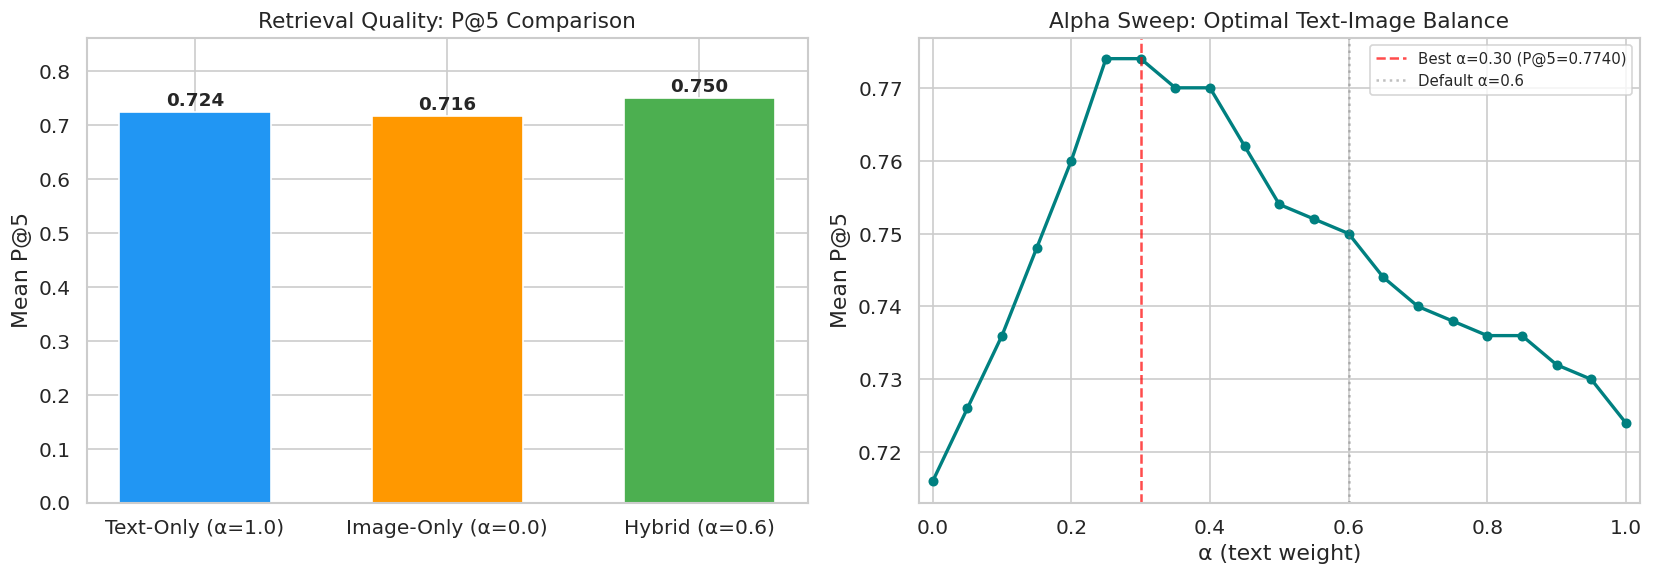

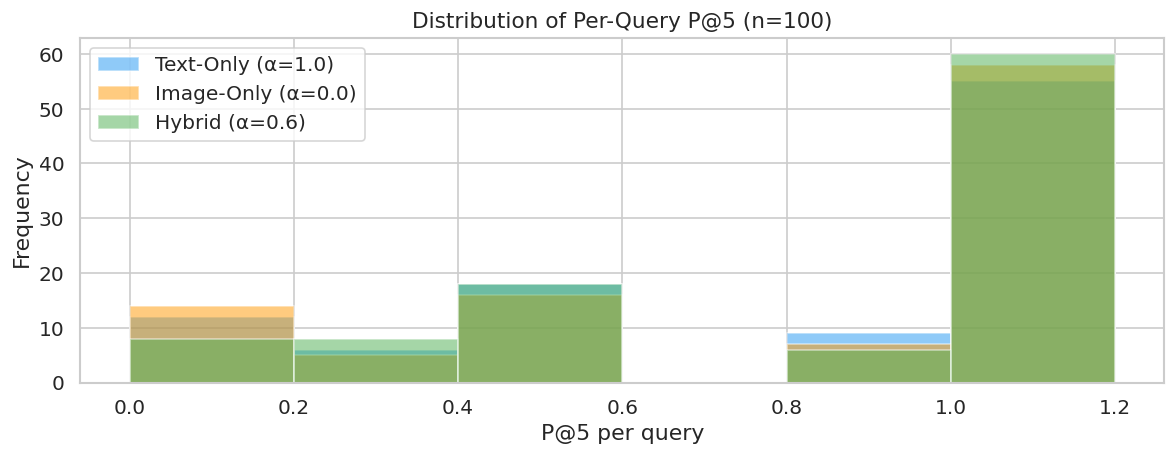

In [24]:
# ============================================================
# Step 5b: Alpha Sweep & Visualization
# ============================================================

# --- Alpha sweep ---
alphas = np.arange(0.0, 1.05, 0.05)
sweep_results = []

print("Running alpha sweep ...")
for a in tqdm(alphas, desc="Alpha sweep"):
    mean_p, _ = evaluate_precision_at_k(alpha=a, query_indices=shared_indices)
    sweep_results.append({"alpha": round(a, 2), "P@5": mean_p})

df_sweep = pd.DataFrame(sweep_results)
best_row = df_sweep.loc[df_sweep["P@5"].idxmax()]
print(f"\nBest alpha: {best_row['alpha']:.2f}  \u2192  P@5 = {best_row['P@5']:.4f}")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (A) Bar chart: Text-Only vs Image-Only vs Hybrid
ax = axes[0]
labels = list(eval_results.keys())
values = [eval_results[l]["mean_p_at_k"] for l in labels]
colors = ["#2196F3", "#FF9800", "#4CAF50"]
bars = ax.bar(labels, values, color=colors, edgecolor="white", width=0.6)
for bar, val in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
        f"{val:.3f}", ha="center", va="bottom", fontsize=11, fontweight="bold",
    )
ax.set_ylabel(f"Mean P@{K}")
ax.set_title(f"Retrieval Quality: P@{K} Comparison", fontsize=13)
ax.set_ylim(0, max(values) * 1.15)

# (B) Line chart: Alpha sweep
ax = axes[1]
ax.plot(df_sweep["alpha"], df_sweep["P@5"], marker="o", color="teal",
        linewidth=2, markersize=5)
ax.axvline(best_row["alpha"], color="red", linestyle="--", alpha=0.7,
           label=f"Best \u03b1={best_row['alpha']:.2f} (P@5={best_row['P@5']:.4f})")
ax.axvline(0.6, color="gray", linestyle=":", alpha=0.5, label="Default \u03b1=0.6")
ax.set_xlabel("\u03b1 (text weight)")
ax.set_ylabel(f"Mean P@{K}")
ax.set_title("Alpha Sweep: Optimal Text-Image Balance", fontsize=13)
ax.legend(fontsize=9)
ax.set_xlim(-0.02, 1.02)

plt.tight_layout()
plt.show()

# --- Per-query distribution ---
fig, ax = plt.subplots(figsize=(10, 4))
for label, color in zip(eval_results.keys(), colors):
    vals = eval_results[label]["per_query"]
    ax.hist(vals, bins=np.arange(0, 1.21, 0.2), alpha=0.5, label=label,
            color=color, edgecolor="white")
ax.set_xlabel(f"P@{K} per query")
ax.set_ylabel("Frequency")
ax.set_title(f"Distribution of Per-Query P@{K} (n={N_QUERIES})", fontsize=13)
ax.legend()
plt.tight_layout()
plt.show()

---

## Step 6 – Interactive Demo

Search the product catalog with natural-language queries and view results with images.

In [25]:
# ============================================================
# Step 6: Interactive Demo – Display Helper
# ============================================================


def display_search_results(
    query: str,
    alpha: float = ALPHA_DEFAULT,
    top_k: int = 5,
    image_base: Optional[Path] = IMAGE_BASE,
) -> None:
    """Search and display results in a visual grid with images.

    Args:
        query: Natural-language search query.
        alpha: Text-image weight balance.
        top_k: Number of results to display.
        image_base: Base path for product images.
    """
    results = hybrid_search(query, alpha=alpha, top_k=top_k)

    fig, axes = plt.subplots(1, top_k, figsize=(4 * top_k, 5.5))
    if top_k == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, results.iterrows()):
        # Attempt to load and display image
        img_loaded = False
        if image_base is not None and pd.notna(row.get("path")):
            img_path = image_base / str(row["path"])
            if img_path.exists():
                try:
                    img = Image.open(img_path).convert("RGB")
                    ax.imshow(img)
                    img_loaded = True
                except Exception:
                    pass

        if not img_loaded:
            ax.text(0.5, 0.5, "No Image\nAvailable",
                    ha="center", va="center", fontsize=11, color="gray",
                    transform=ax.transAxes)
            ax.set_facecolor("#f5f5f5")

        # Title and metadata
        title = str(row.get("item_name_flat", ""))[:55]
        ptype = str(row.get("product_type_flat", ""))
        brand = str(row.get("brand_flat", "")) if pd.notna(row.get("brand_flat")) else ""
        h_score = row.get("hybrid_score", 0)
        t_score = row.get("text_sim", 0)
        i_score = row.get("image_sim", 0)

        label = (
            f"#{int(row['_rank'])} {title}\n"
            f"[{ptype}]{(' | ' + brand) if brand else ''}\n"
            f"H={h_score:.3f}  T={t_score:.3f}  I={i_score:.3f}"
        )
        ax.set_title(label, fontsize=8, pad=6)
        ax.axis("off")

    fig.suptitle(
        f'Query: "{query}"  (\u03b1={alpha})',
        fontsize=14, fontweight="bold", y=1.02,
    )
    plt.tight_layout()
    plt.show()

    # Print tabular results
    display_cols = ["_rank", "item_name_flat", "product_type_flat", "brand_flat",
                    "hybrid_score", "text_sim", "image_sim"]
    display_cols = [c for c in display_cols if c in results.columns]
    display(results[display_cols].reset_index(drop=True))


print("\u2713 display_search_results() defined")

✓ display_search_results() defined


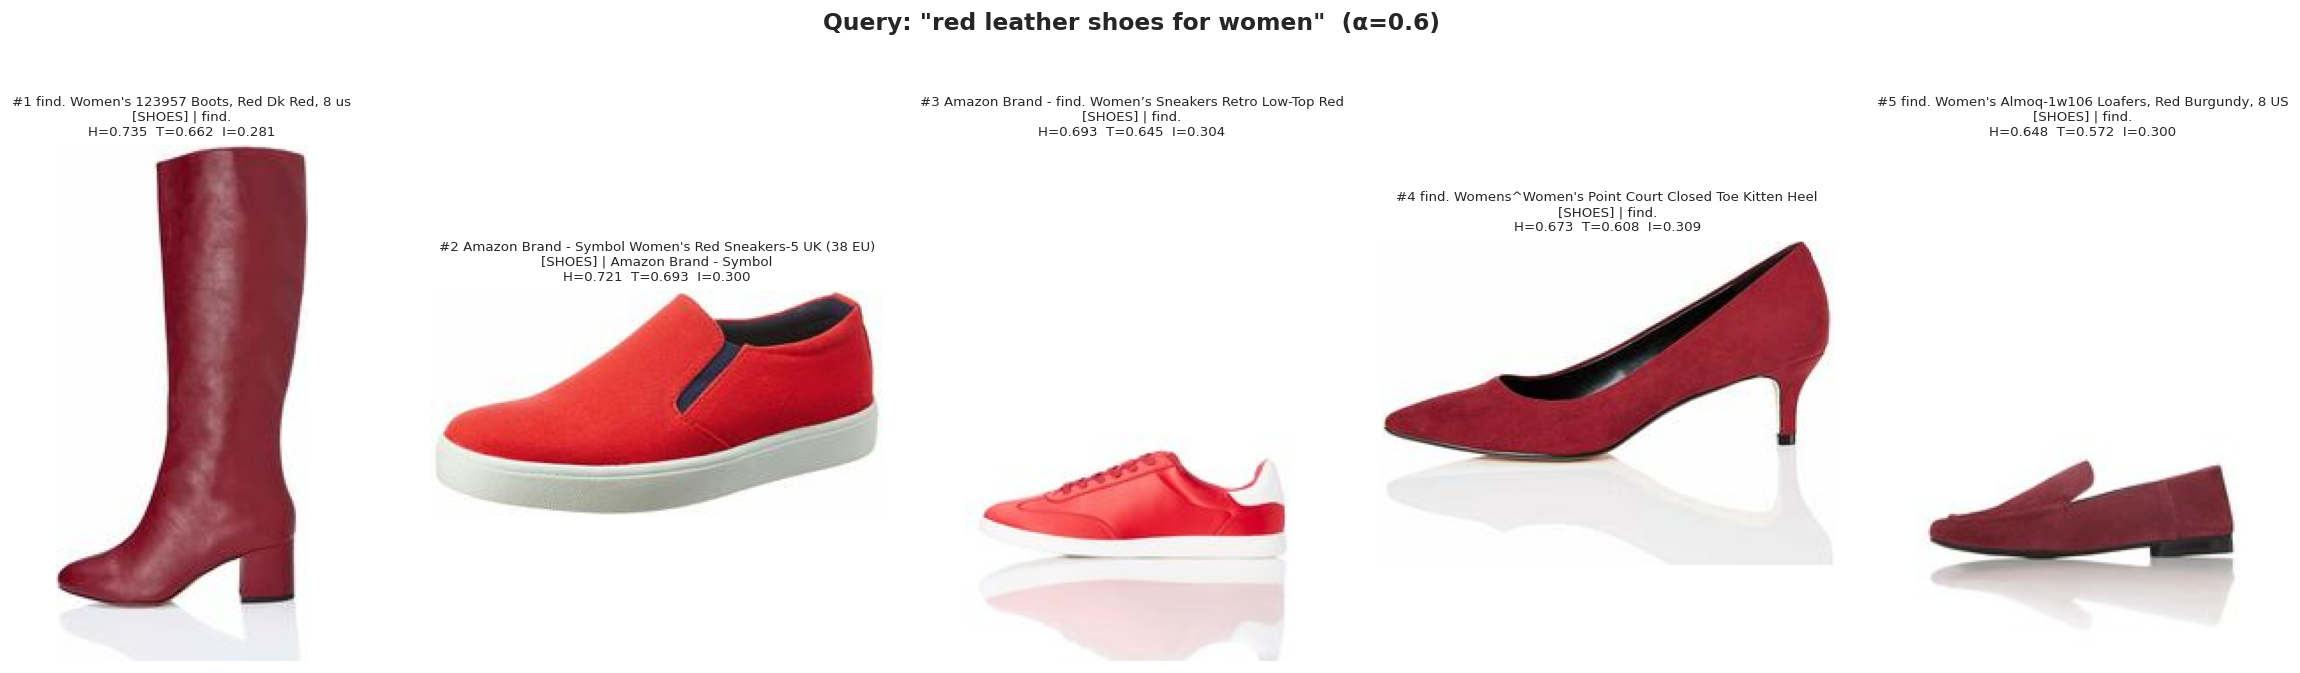

_rank  \
0      1   
1      2   
2      3   
3      4   
4      5   

                                                                 item_name_flat  \
0                                  find. Women's 123957 Boots, Red Dk Red, 8 us   
1    Amazon Brand - Symbol Women's Red Sneakers-5 UK (38 EU) (8 US) (AZ-WSY-07)   
2               Amazon Brand - find. Women’s Sneakers Retro Low-Top Red US 10.5   
3  find. Womens^Women's Point Court Closed Toe Kitten Heels, Red Burgundy, 8 us   
4                         find. Women's Almoq-1w106 Loafers, Red Burgundy, 8 US   

  product_type_flat             brand_flat  hybrid_score  text_sim  image_sim  
0             SHOES                  find.      0.734529  0.662186   0.280543  
1             SHOES  Amazon Brand - Symbol      0.720703  0.693113   0.299587  
2             SHOES                  find.      0.693364  0.644902   0.303557  
3             SHOES                  find.      0.673019  0.607652   0.308569  
4             SHOES                  find.      0.648456  0.572345   0.300122

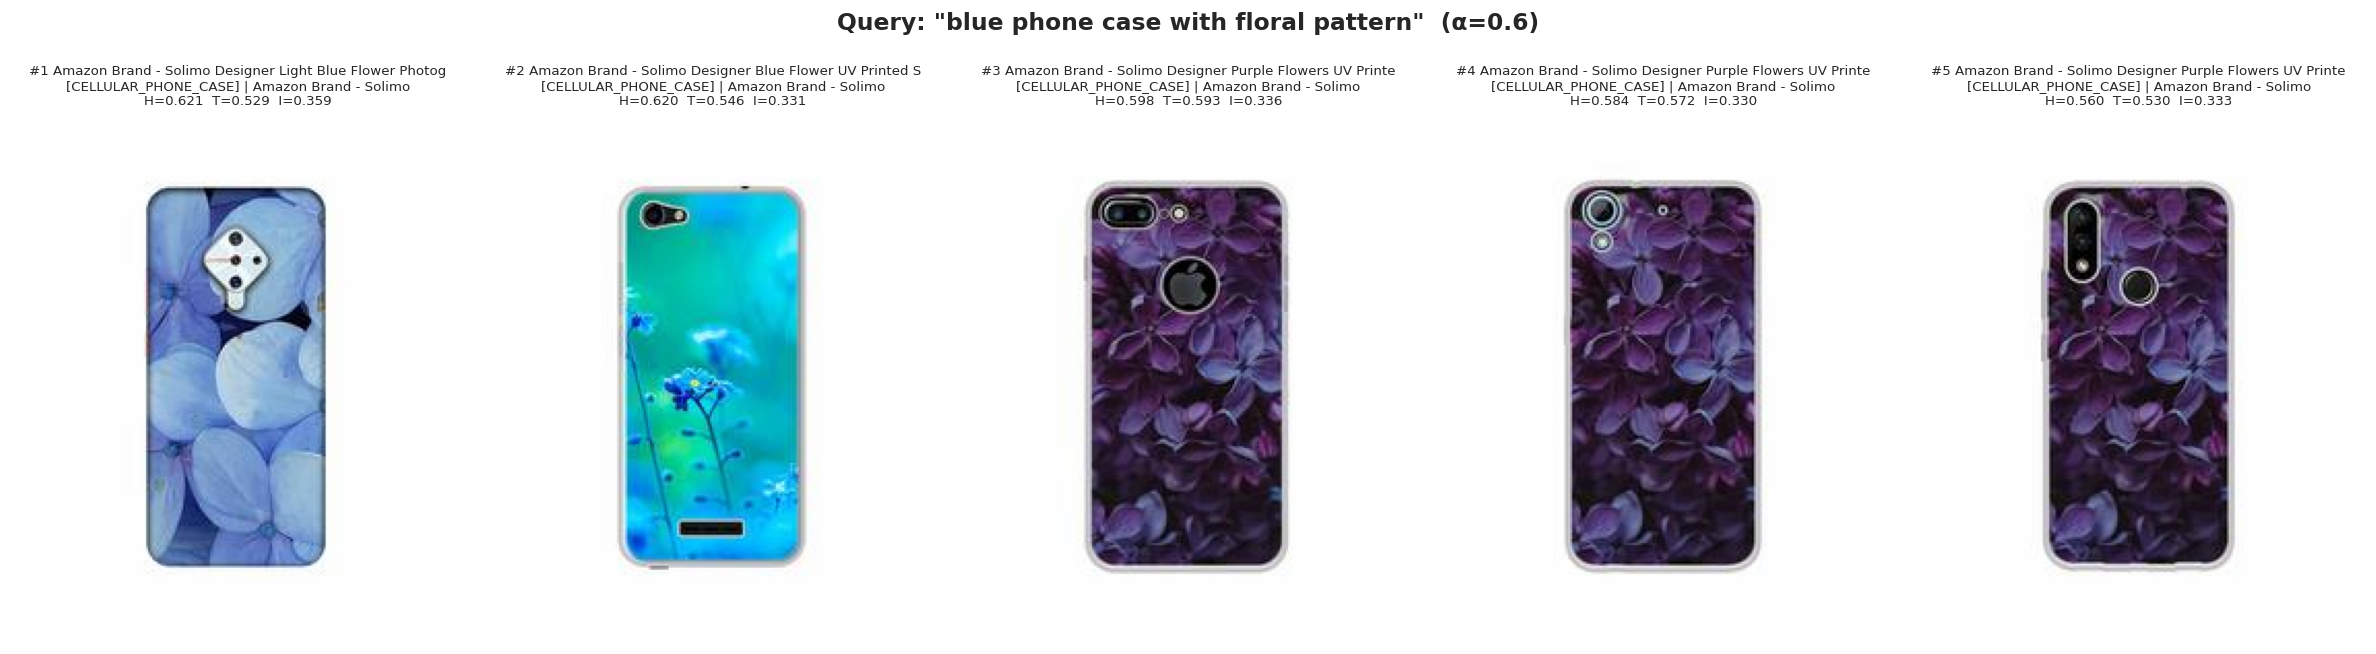

_rank  \
0      1   
1      2   
2      3   
3      4   
4      5   

                                                                                                            item_name_flat  \
0      Amazon Brand - Solimo Designer Light Blue Flower Photography 3D Printed Hard Back Case Mobile Cover for Vivo S1 Pro   
1                           Amazon Brand - Solimo Designer Blue Flower UV Printed Soft Back Case Mobile Cover for Lava Z61   
2  Amazon Brand - Solimo Designer Purple Flowers UV Printed Soft Back Case Mobile Cover for Apple iPhone 7 Plus (Logo Cut)   
3   Amazon Brand - Solimo Designer Purple Flowers UV Printed Soft Back Case Mobile Cover for HTC Desire 626/HTC Desire 628   
4                  Amazon Brand - Solimo Designer Purple Flowers UV Printed Soft Back Case Mobile Cover for Lenovo A6 Note   

     product_type_flat             brand_flat  hybrid_score  text_sim  \
0  CELLULAR_PHONE_CASE  Amazon Brand - Solimo      0.620919  0.528779   
1  CELLULAR_PHONE_CASE  Amazon Brand - Solimo      0.620036  0.546129   
2  CELLULAR_PHONE_CASE  Amazon Brand - Solimo      0.598448  0.593407   
3  CELLULAR_PHONE_CASE  Amazon Brand - Solimo      0.583557  0.572478   
4  CELLULAR_PHONE_CASE  Amazon Brand - Solimo      0.559646  0.530444   

   image_sim  
0   0.359130  
1   0.330896  
2   0.336010  
3   0.330175  
4   0.333449

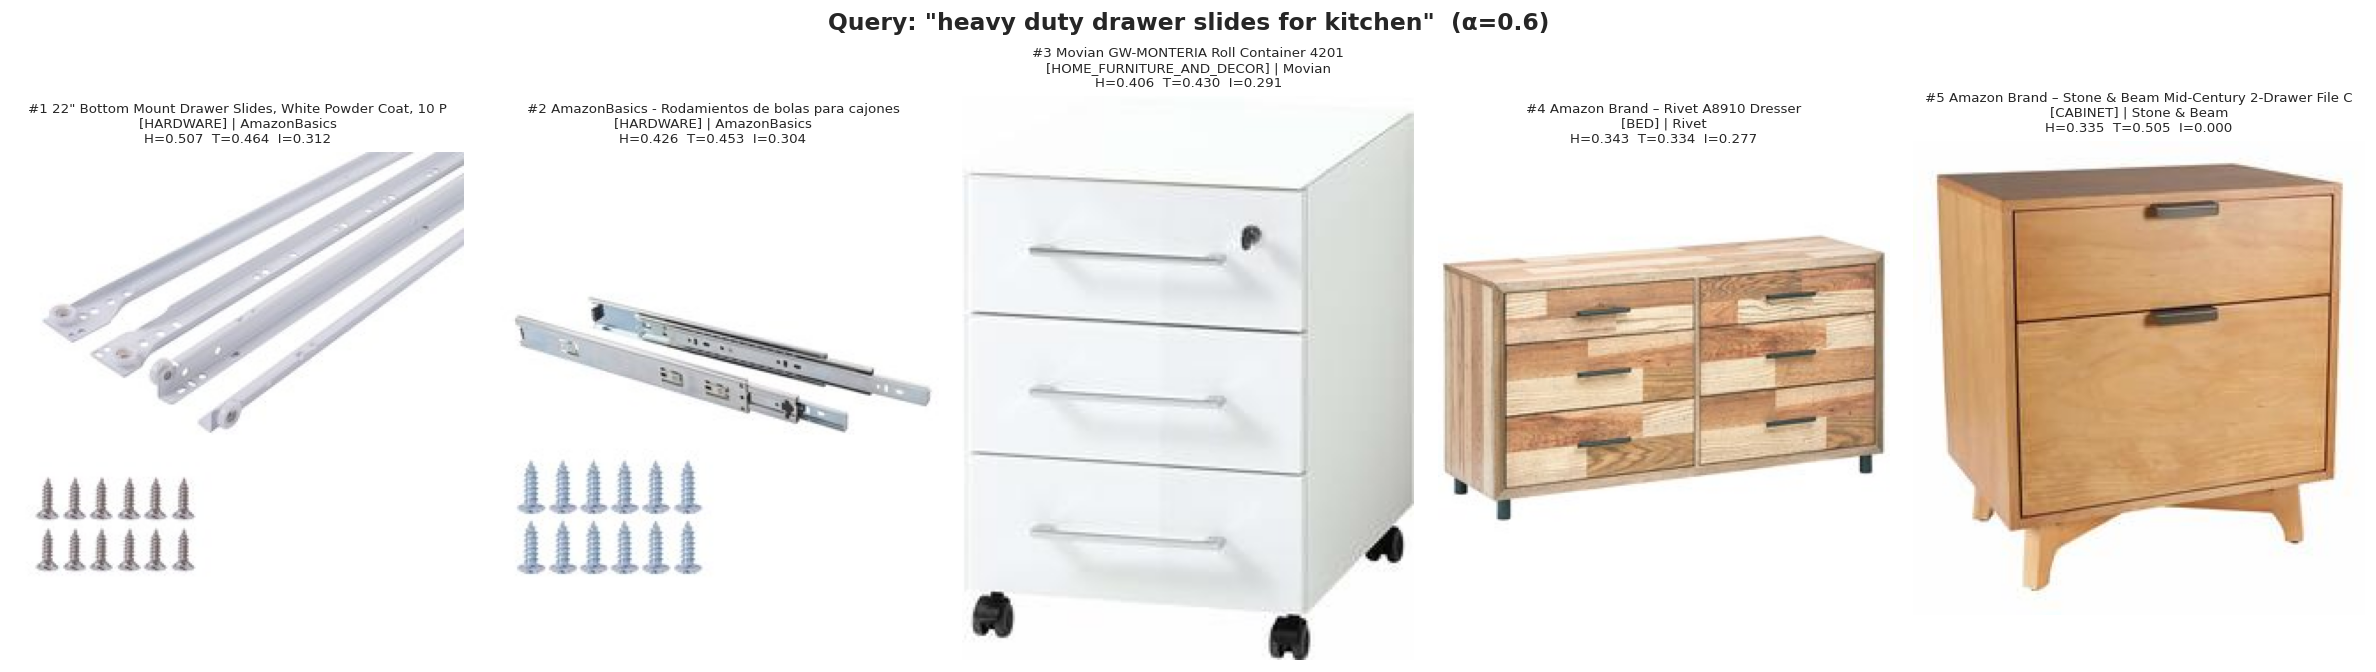

_rank  \
0      1   
1      2   
2      3   
3      4   
4      5   

                                                                       item_name_flat  \
0                         22" Bottom Mount Drawer Slides, White Powder Coat, 10 Pairs   
1                                    AmazonBasics - Rodamientos de bolas para cajones   
2                                              Movian GW-MONTERIA Roll Container 4201   
3                                                  Amazon Brand – Rivet A8910 Dresser   
4  Amazon Brand – Stone & Beam Mid-Century 2-Drawer File Cabinet, 21.7"W, Pine Finish   

          product_type_flat    brand_flat  hybrid_score  text_sim  image_sim  
0                  HARDWARE  AmazonBasics      0.506809  0.463563   0.311679  
1                  HARDWARE  AmazonBasics      0.425540  0.453303   0.303895  
2  HOME_FURNITURE_AND_DECOR        Movian      0.406294  0.430097   0.290589  
3                       BED         Rivet      0.342914  0.333559   0.276947  
4                   CABINET  Stone & Beam      0.335095  0.505158   0.000000

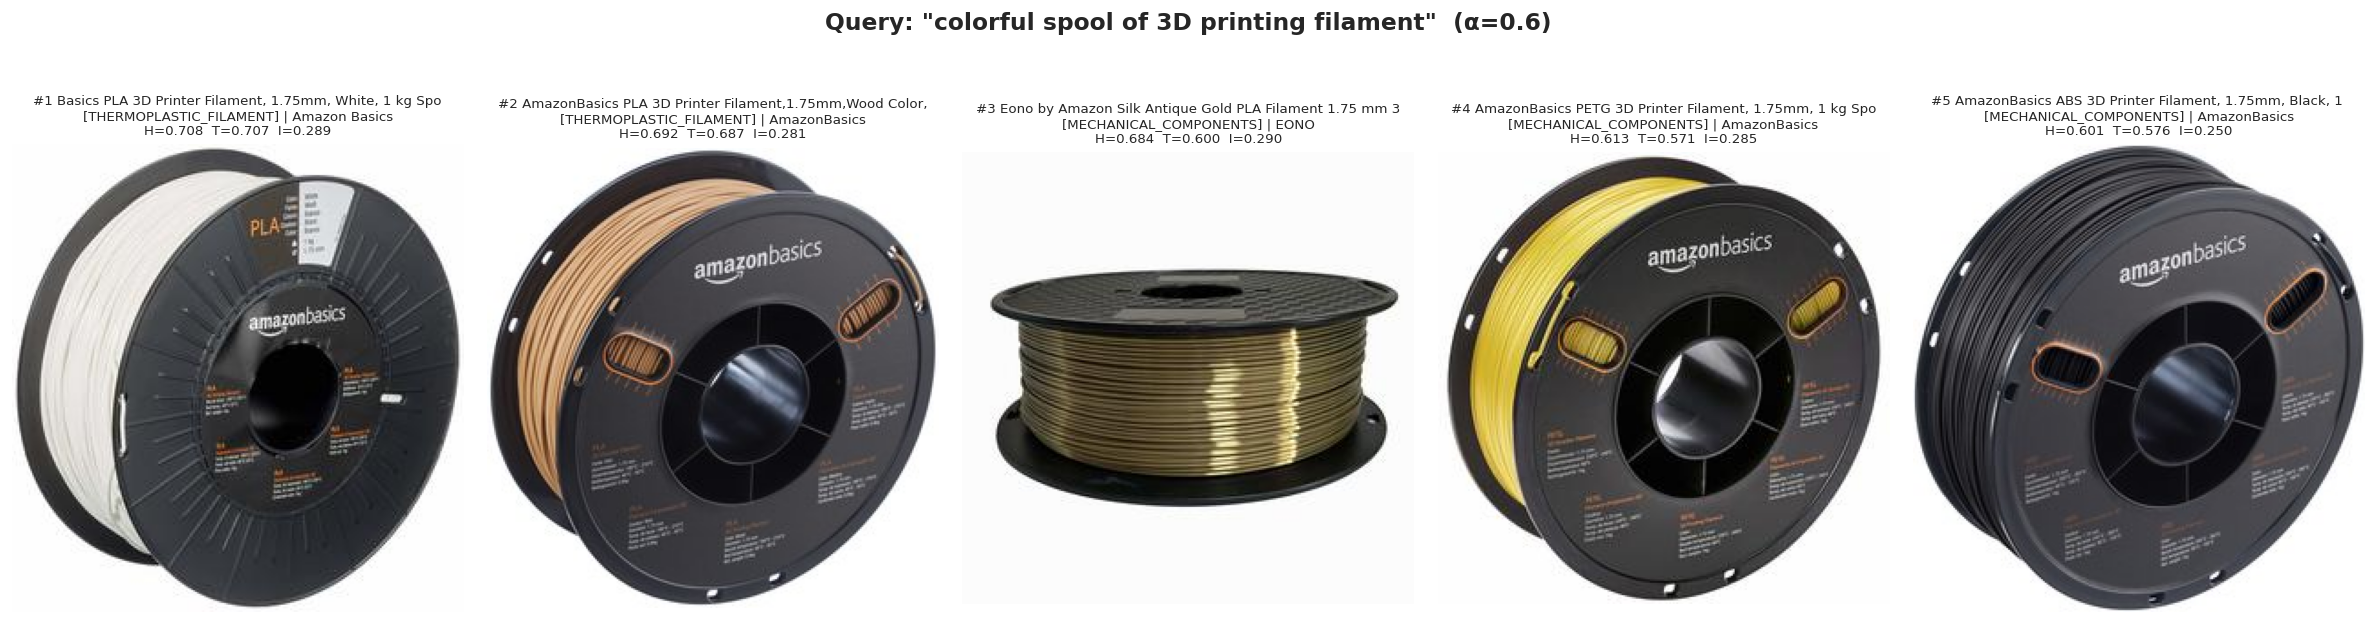

_rank  \
0      1   
1      2   
2      3   
3      4   
4      5   

                                                                                                            item_name_flat  \
0                                                                Basics PLA 3D Printer Filament, 1.75mm, White, 1 kg Spool   
1                                                      AmazonBasics PLA 3D Printer Filament,1.75mm,Wood Color,0.8 kg Spool   
2  Eono by Amazon Silk Antique Gold PLA Filament 1.75 mm 3D Printer Filament 1KG 2.2 LBS Spool 3D Printing Material Sil...   
3                                          AmazonBasics PETG 3D Printer Filament, 1.75mm, 1 kg Spool 1.75mm AMG10528516-10   
4                                                          AmazonBasics ABS 3D Printer Filament, 1.75mm, Black, 1 kg Spool   

        product_type_flat     brand_flat  hybrid_score  text_sim  image_sim  
0  THERMOPLASTIC_FILAMENT  Amazon Basics      0.707698  0.706688   0.289212  
1  THERMOPLASTIC_FILAMENT   AmazonBasics      0.692423  0.687037   0.280502  
2   MECHANICAL_COMPONENTS           EONO      0.683748  0.599581   0.289999  
3   MECHANICAL_COMPONENTS   AmazonBasics      0.612693  0.571036   0.285179  
4   MECHANICAL_COMPONENTS   AmazonBasics      0.601330  0.575739   0.249715

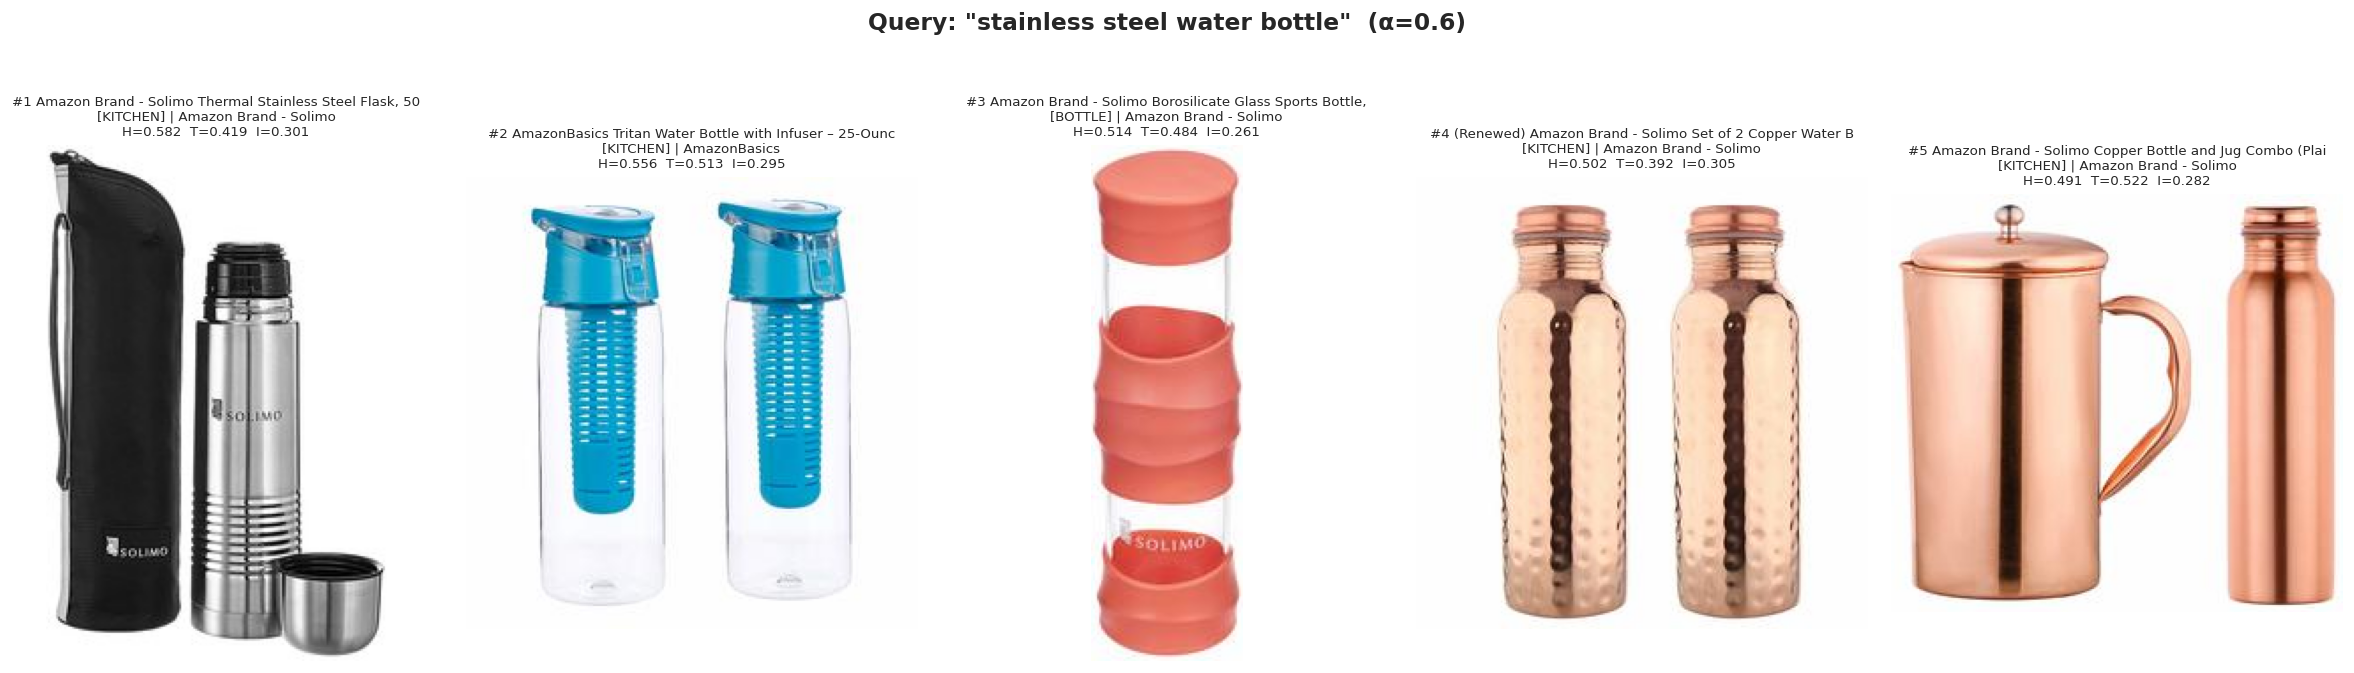

_rank  \
0      1   
1      2   
2      3   
3      4   
4      5   

                                                                    item_name_flat  \
0                      Amazon Brand - Solimo Thermal Stainless Steel Flask, 500 ml   
1           AmazonBasics Tritan Water Bottle with Infuser – 25-Ounce, 2-Pack, Blue   
2           Amazon Brand - Solimo Borosilicate Glass Sports Bottle, 470 ml, Orange   
3  (Renewed) Amazon Brand - Solimo Set of 2 Copper Water Bottles (Hammered, 700ml)   
4                        Amazon Brand - Solimo Copper Bottle and Jug Combo (Plain)   

  product_type_flat             brand_flat  hybrid_score  text_sim  image_sim  
0           KITCHEN  Amazon Brand - Solimo      0.581823  0.418981   0.301085  
1           KITCHEN           AmazonBasics      0.555759  0.512645   0.295430  
2            BOTTLE  Amazon Brand - Solimo      0.514450  0.483721   0.260542  
3           KITCHEN  Amazon Brand - Solimo      0.502255  0.391874   0.305327  
4           KITCHEN  Amazon Brand - Solimo      0.491079  0.522152   0.281969

In [26]:
# ============================================================
# Step 6b: Interactive Demo – Sample Queries
# ============================================================

INTERACTIVE_QUERIES = [
    "red leather shoes for women",
    "blue phone case with floral pattern",
    "heavy duty drawer slides for kitchen",
    "colorful spool of 3D printing filament",
    "stainless steel water bottle",
]

for query in INTERACTIVE_QUERIES:
    display_search_results(query, alpha=ALPHA_DEFAULT, top_k=5)
    print()

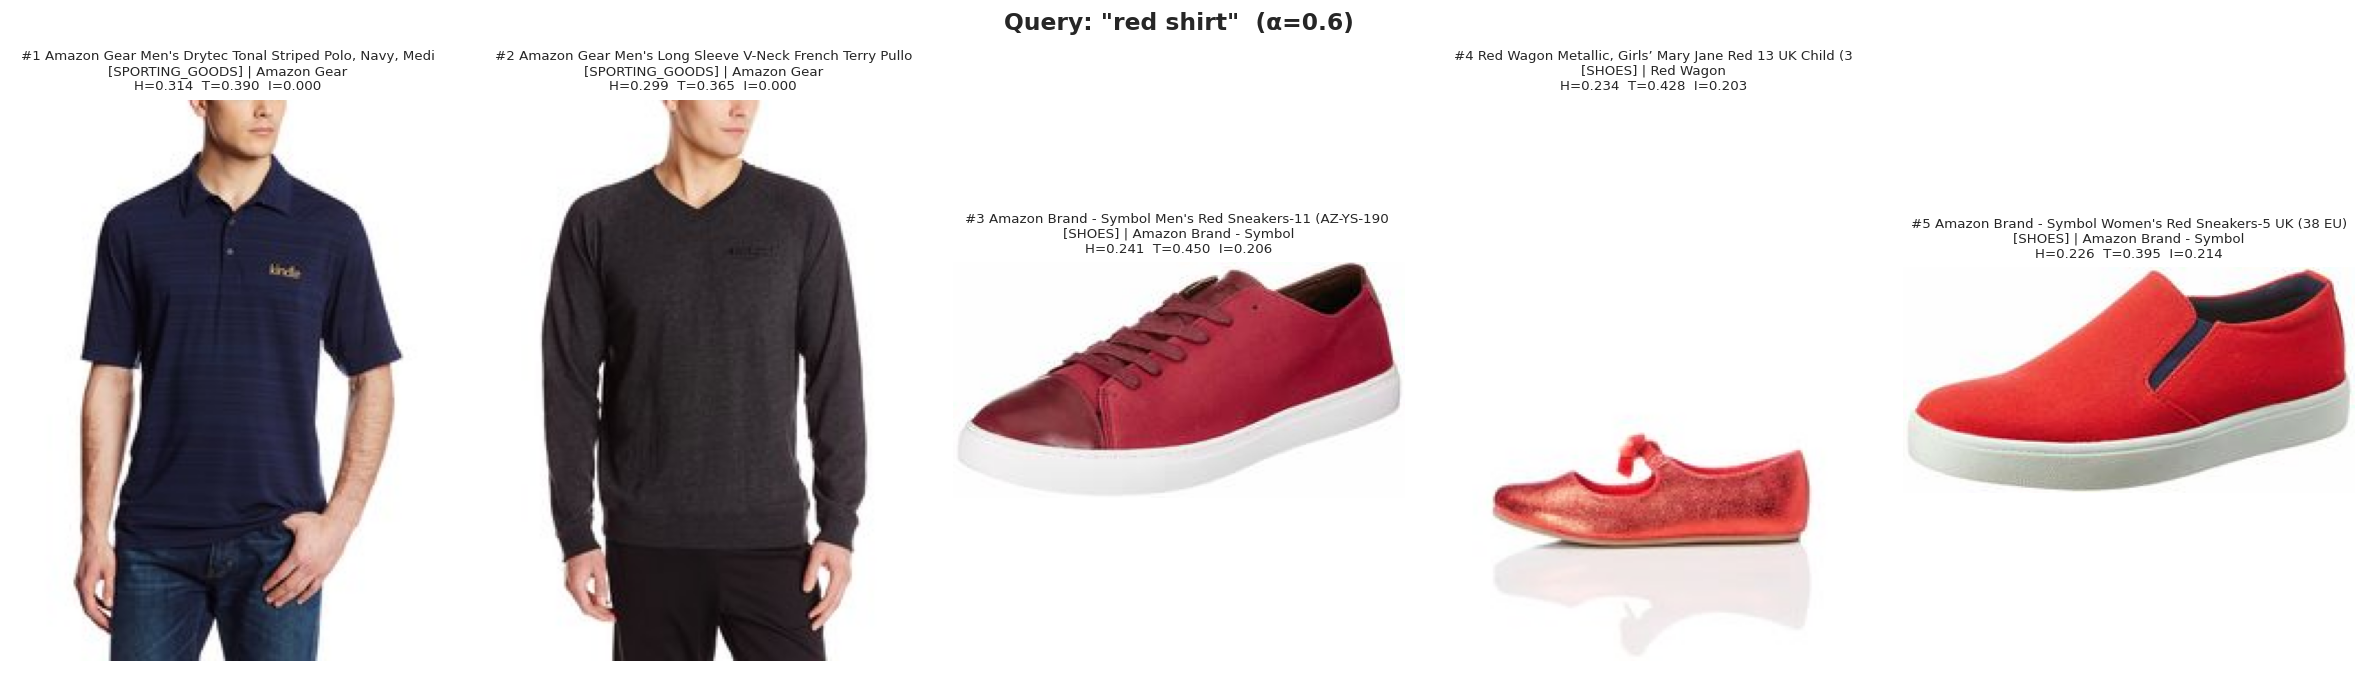

_rank  \
0      1   
1      2   
2      3   
3      4   
4      5   

                                                                     item_name_flat  \
0                         Amazon Gear Men's Drytec Tonal Striped Polo, Navy, Medium   
1  Amazon Gear Men's Long Sleeve V-Neck French Terry Pullover with Tonal Embroidery   
2                         Amazon Brand - Symbol Men's Red Sneakers-11 (AZ-YS-190 B)   
3                      Red Wagon Metallic, Girls’ Mary Jane Red 13 UK Child (32 EU)   
4        Amazon Brand - Symbol Women's Red Sneakers-5 UK (38 EU) (8 US) (AZ-WSY-07)   

  product_type_flat             brand_flat  hybrid_score  text_sim  image_sim  
0    SPORTING_GOODS            Amazon Gear      0.313725  0.389541   0.000000  
1    SPORTING_GOODS            Amazon Gear      0.299185  0.365308   0.000000  
2             SHOES  Amazon Brand - Symbol      0.241072  0.449537   0.206052  
3             SHOES              Red Wagon      0.233839  0.427505   0.202940  
4             SHOES  Amazon Brand - Symbol      0.226332  0.394799   0.214461

In [27]:
# ============================================================
# Step 6c: Try Your Own Query
# ============================================================
# Change the query below and re-run this cell!

MY_QUERY = "red shirt"
display_search_results(MY_QUERY, alpha=0.6, top_k=5)

---

## Summary & Key Findings

### Embedding Quality Benchmark (P@5, 100 queries, seed=42)

| Mode | P@5 | Notes |
|------|-----|-------|
| **Text-Only** (α=1.0) | 0.7240 | SentenceTransformer (`all-MiniLM-L6-v2`, 384d) on enriched text |
| **Image-Only** (α=0.0) | 0.7160 | CLIP (`openai/clip-vit-base-patch32`, 512d) image embeddings |
| **Hybrid** (α=0.6) | **0.7500** | Weighted score-level fusion — **best of the three fixed-α baselines** |
| **Sweep best** (α=0.30) | **0.7740** | Alpha sweep optimum — image-weighted raw retrieval |

> Hybrid retrieval outperforms both unimodal baselines. The alpha sweep (Step 5b) finds the raw-vector optimum at **α ≈ 0.30** (P@5 = 0.7740), indicating strong image signal in the ABO dataset. In production, the Stage-2 reranking adds text-based features (lexical, title, and type overlap plus head-noun and gender guards), so the default **α = 0.6** balances well with the post-retrieval text boost — the sweep measures Stage 1 only, while the qualitative results reflect the full two-stage pipeline.

### Two-Stage Retrieval Architecture

**Stage 1 — Hybrid vector retrieval:**
```
hybrid_score = α · text_sim + (1 − α) · image_sim
```
- α is **dynamic** per query: visual queries (e.g., "colorful design") lower α to 0.30; technical queries (e.g., "3D printer") raise α to 0.70.

**Stage 2 — Production reranking (additive + multiplicative):**
```
adjusted  = hybrid_score + w_lex·lexical + w_title·title + w_type·type
final     = adjusted × head_noun_mult × gender_mult
```

| Feature | Type | Purpose |
|---------|------|---------|
| Lexical overlap | Additive (w=0.16) | Query tokens vs enriched_text + title + type |
| Title overlap | Additive (w=0.10) | Query tokens vs item_name_flat |
| Type overlap | Additive (w=0.06) | Query tokens vs product_type_flat |
| Head-noun guard | Multiplicative (×0.5) | Penalizes results missing the query's product noun (e.g., "shirt", "filament") |
| Compound noun expansion | Lookup | "t-shirt" → also matches "shirt" via hyphen splitting |
| Gender intent | Multiplicative (×0.6) | Detects women/men tokens; penalizes gender-mismatched results |
| Dynamic alpha | Per-query | Visual cues → lower α; technical cues / numbers → higher α |
| Confidence cutoff | Filter (0.30) | Low-scoring results removed; fewer but more relevant results returned |
| ABO category hints | Dataset-aware | 30+ product-type mappings for head-noun-to-type alignment |

### Qualitative Results (Step 4b + Step 6b)

| Query | Top-5 Quality | Key Feature |
|-------|--------------|-------------|
| "red shoes for women" | ✅ All women's shoes | Gender guard eliminated men's shoes |
| "3D printer filament" | ✅ All filament products | Dynamic α=0.70; head nouns matched |
| "phone case with colorful design" | ✅ All phone cases | Dynamic α=0.30 (visual shift) |
| "kitchen drawer slides hardware" | ✅ Drawer slides #1; related hardware #2-5 | Head nouns + type matching |
| "comfortable cotton t-shirt" | ✅ Clothing above bedding | Compound noun expansion; HN penalty on pillows |
| "red leather shoes for women" | ✅ All women's red shoes with images | Gender + head noun + image sim |
| "blue phone case with floral pattern" | ✅ All floral phone cases | Dynamic α leveraged image similarity |
| "stainless steel water bottle" | ✅ All bottles/flasks | Text similarity on materials |

### Architecture Decisions

1. **Two-model approach**: SentenceTransformer (384d) for dense text ↔ CLIP (512d) for cross-modal image search. Combined at the **score level**, not embedding level — allows independent optimization.
2. **Dynamic alpha**: Automatically adapts retrieval balance based on query characteristics, eliminating the need for a single static weight.
3. **Multiplicative penalties**: Head-noun and gender guards use `score × (1 − penalty)` rather than additive subtraction, ensuring even high-similarity mismatches are suppressed.
4. **Dual backend**: Persistent **ChromaDB** for production-shaped retrieval; in-memory NumPy for fast evaluation sweeps.
5. **Confidence cutoff**: Returns fewer results when catalog coverage is weak, preventing irrelevant items from filling the list.

### NB02 → NB03 Artifact Continuity

| Artifact | Produced by NB02 | Consumed by NB03 |
|----------|------------------|------------------|
| `enriched_products_full.pkl` | ✅ | ✅ Primary metadata source |
| `embedding_index.csv` | ✅ | ✅ Row alignment |
| `image_embeddings.npy` (512d) | ✅ | ✅ IMAGE_INDEX |
| `text_embeddings.npy` (512d) | ✅ | ⚠️ Loaded but recomputed (384d encoder) |
| `hybrid_embeddings.npy` | ✅ | ℹ️ Loaded for analysis, not used in retrieval |

### Next Steps

1. **`04-fine-tuning.ipynb`** — LLM integration with curated result wrapper (`get_curated_results`) and fine-tuning dataset generation.
2. **Voice interface** — Whisper STT for voice-based shopping queries.
3. **Production ingestion** (`backend/scripts/ingest_abo.py`) — Reuse persistent ChromaDB schema.
4. **Streamlit UI** — Chat interface with hybrid search backend (Phase 4).

---

## Step 7 — Export Artifacts for NB04

Save all critical outputs so **`04-fine-tuning.ipynb`** can load them without re-running NB03.

| Artifact | Format | Purpose in NB04 |
|----------|--------|-----------------|
| `rag_products.pkl` | Pickle (DataFrame) | Full product catalogue with enriched text, metadata, and search fields |
| `rag_text_index.npy` | NumPy (N × 384) | Pre-normalised SentenceTransformer embeddings for text retrieval |
| `rag_image_index.npy` | NumPy (N × 512) | Pre-normalised CLIP embeddings for image retrieval |
| `rag_config.json` | JSON | All retrieval & reranking hyperparameters, model IDs, benchmark results |
| `rag_alpha_sweep.csv` | CSV | Full alpha-sweep curve for reporting |
| `chroma_db/` | ChromaDB dir | Persistent vector collections (text + image) |

In [30]:
# ============================================================
# Step 7: Export Artifacts for NB04
# ============================================================

import json

EXPORT_DIR = Path("/kaggle/working")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------------
# 1. Product catalogue (full dataframe used during retrieval)
# ------------------------------------------------------------------
pkl_path = EXPORT_DIR / "rag_products.pkl"
df.to_pickle(pkl_path)
print(f"✓ {pkl_path.name:30s}  {pkl_path.stat().st_size / 1e6:.1f} MB  ({len(df):,} rows × {len(df.columns)} cols)")

# ------------------------------------------------------------------
# 2. Pre-normalised embedding indexes (NumPy)
# ------------------------------------------------------------------
text_path = EXPORT_DIR / "rag_text_index.npy"
image_path = EXPORT_DIR / "rag_image_index.npy"

np.save(text_path, TEXT_INDEX)
np.save(image_path, IMAGE_INDEX)

print(f"✓ {text_path.name:30s}  {text_path.stat().st_size / 1e6:.1f} MB  shape={TEXT_INDEX.shape}")
print(f"✓ {image_path.name:30s}  {image_path.stat().st_size / 1e6:.1f} MB  shape={IMAGE_INDEX.shape}")

# ------------------------------------------------------------------
# 3. Configuration + benchmark results (JSON)
# ------------------------------------------------------------------
config = {
    # --- Models ---
    "text_model_id": ST_MODEL_ID,
    "text_embedding_dim": int(TEXT_INDEX.shape[1]),
    "image_model_id": CLIP_MODEL_ID,
    "image_embedding_dim": int(IMAGE_INDEX.shape[1]),

    # --- Retrieval ---
    "alpha_default": ALPHA_DEFAULT,
    "search_backend": SEARCH_BACKEND,
    "use_chroma": USE_CHROMA,

    # --- Reranking ---
    "rerank_enabled": RERANK_ENABLED,
    "lexical_weight": LEXICAL_WEIGHT,
    "title_weight": TITLE_WEIGHT,
    "type_weight": TYPE_WEIGHT,
    "head_noun_miss_penalty": HEAD_NOUN_MISS_PENALTY,
    "gender_miss_penalty": GENDER_MISS_PENALTY,
    "low_confidence_cutoff": LOW_CONFIDENCE_CUTOFF,
    "abo_category_hint_count": len(ABO_CATEGORY_HINTS),

    # --- Benchmark (P@5, 100 queries, seed=42) ---
    "eval_results": {
        label: {
            "mean_p_at_k": round(float(res["mean_p_at_k"]), 4),
            "elapsed_s": round(float(res.get("elapsed_s", 0)), 2),
        }
        for label, res in eval_results.items()
    },
    "best_alpha_sweep": {
        "alpha": round(float(best_row["alpha"]), 2),
        "p_at_5": round(float(best_row["P@5"]), 4),
    },

    # --- Dataset stats ---
    "total_products": len(df),
    "product_type_count": int(df["product_type_flat"].nunique()),
    "device": str(DEVICE),
    "gpu_name": GPU_NAME,
}

config_path = EXPORT_DIR / "rag_config.json"
with open(config_path, "w") as f:
    json.dump(config, f, indent=2)
print(f"✓ {config_path.name:30s}  {config_path.stat().st_size / 1e3:.1f} KB")

# ------------------------------------------------------------------
# 4. Alpha sweep curve (CSV — handy for NB04 reporting / plots)
# ------------------------------------------------------------------
sweep_path = EXPORT_DIR / "rag_alpha_sweep.csv"
df_sweep.to_csv(sweep_path, index=False)
print(f"✓ {sweep_path.name:30s}  {sweep_path.stat().st_size / 1e3:.1f} KB  ({len(df_sweep)} rows)")

# ------------------------------------------------------------------
# 5. ChromaDB — already persisted automatically
# ------------------------------------------------------------------
if USE_CHROMA:
    chroma_size = sum(f.stat().st_size for f in Path(CHROMA_DIR).rglob("*") if f.is_file())
    print(f"✓ {'chroma_db/':30s}  {chroma_size / 1e6:.1f} MB  (auto-persisted)")
else:
    print("ℹ ChromaDB not active — skipped")

# ------------------------------------------------------------------
# Summary
# ------------------------------------------------------------------
print(f"\nExport complete. Files in {EXPORT_DIR}/:")
for p in sorted(EXPORT_DIR.glob("rag_*")):
    print(f"  {p.name:35s} {p.stat().st_size / 1e6:>8.1f} MB")
if USE_CHROMA:
    print(f"  {'chroma_db/':35s} {chroma_size / 1e6:>8.1f} MB")

✓ rag_products.pkl                77.9 MB  (9,190 rows × 51 cols)
✓ rag_text_index.npy              14.1 MB  shape=(9190, 384)
✓ rag_image_index.npy             18.8 MB  shape=(9190, 512)
✓ rag_config.json                 0.9 KB
✓ rag_alpha_sweep.csv             0.4 KB  (21 rows)
✓ chroma_db/                      267.9 MB  (auto-persisted)

Export complete. Files in /kaggle/working/:
  rag_alpha_sweep.csv                      0.0 MB
  rag_config.json                          0.0 MB
  rag_image_index.npy                     18.8 MB
  rag_products.pkl                        77.9 MB
  rag_text_index.npy                      14.1 MB
  chroma_db/                             267.9 MB


In [31]:
# ============================================================
# Final Summary (auto-fill)
# ============================================================

print("=" * 60)
print("SHOPTALK RAG PROTOTYPE — SUMMARY")
print("=" * 60)

print("\n--- Data & Index ---")
print(f"  Total Products Indexed:  {len(df):,}")
print(f"  Product Types:           {df['product_type_flat'].nunique()}")
print(f"  Text Embedding Model:    {ST_MODEL_ID}")
print(f"  Text Embedding Dim:      {TEXT_INDEX.shape[1]}")
print(f"  Image Embedding Model:   {CLIP_MODEL_ID}")
print(f"  Image Embedding Dim:     {IMAGE_INDEX.shape[1]}")
print(f"  Search Backend:          {SEARCH_BACKEND}")
print(f"  Device Used:             {DEVICE} ({GPU_NAME})")

print("\n--- Retrieval Config ---")
print(f"  Default Alpha:           {ALPHA_DEFAULT} (dynamic when rerank enabled)")
print(f"  Rerank Enabled:          {RERANK_ENABLED}")
print(f"  Lexical Weight:          {LEXICAL_WEIGHT}")
print(f"  Title Weight:            {TITLE_WEIGHT}")
print(f"  Type Weight:             {TYPE_WEIGHT}")
print(f"  Head-Noun Miss Penalty:  {HEAD_NOUN_MISS_PENALTY} (multiplicative)")
print(f"  Gender Miss Penalty:     {GENDER_MISS_PENALTY} (multiplicative)")
print(f"  Low Confidence Cutoff:   {LOW_CONFIDENCE_CUTOFF}")
print(f"  ABO Category Hints:      {len(ABO_CATEGORY_HINTS)} entries")

print("\n--- Embedding Quality (P@5, 100 queries, seed=42) ---")
for label, res in eval_results.items():
    print(f"  {label:25s}  P@5 = {res['mean_p_at_k']:.4f}")
print(f"\n  Best Alpha (sweep):      {best_row['alpha']:.2f} -> P@5 = {best_row['P@5']:.4f}")
print(f"  Note: sweep measures Stage-1 raw retrieval only.")
print(f"  Production default α={ALPHA_DEFAULT} accounts for Stage-2 text-based reranking.")

print("\n" + "=" * 60)
print("RAG prototype complete. Next: 04-fine-tuning.ipynb")
print("=" * 60)

SHOPTALK RAG PROTOTYPE — SUMMARY

--- Data & Index ---
  Total Products Indexed:  9,190
  Product Types:           334
  Text Embedding Model:    all-MiniLM-L6-v2
  Text Embedding Dim:      384
  Image Embedding Model:   openai/clip-vit-base-patch32
  Image Embedding Dim:     512
  Search Backend:          chroma
  Device Used:             cuda (Tesla T4)

--- Retrieval Config ---
  Default Alpha:           0.6 (dynamic when rerank enabled)
  Rerank Enabled:          True
  Lexical Weight:          0.16
  Title Weight:            0.1
  Type Weight:             0.06
  Head-Noun Miss Penalty:  0.5 (multiplicative)
  Gender Miss Penalty:     0.4 (multiplicative)
  Low Confidence Cutoff:   0.3
  ABO Category Hints:      35 entries

--- Embedding Quality (P@5, 100 queries, seed=42) ---
  Text-Only (α=1.0)          P@5 = 0.7240
  Image-Only (α=0.0)         P@5 = 0.7160
  Hybrid (α=0.6)             P@5 = 0.7500

  Best Alpha (sweep):      0.30 -> P@5 = 0.7740
  Note: sweep measures Stage-1 ra